# Deep Learning Basics with PyTorch
# Part I — Foundations of Machine Learning
## Exercises

---
## *Appendix A — NumPy Warm-Up*
---

### Array Construction

In [1]:
import numpy as np

np.set_printoptions(precision=3, suppress=True)

A = np.tile(np.arange(3).reshape(3,1), (1,4))
A

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])

### Sampling and Statistics

In [2]:
import pandas as pd

df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "CIB"
returns = df[f"{ticker}_Price"].pct_change().dropna()

sample = returns.sample(10000, replace=True, random_state=42)
print(f"mean = {sample.mean():.6f}, std = {sample.std():.6f}")

mean = 0.000660, std = 0.024092


### Broadcasting

In [3]:
window = 20
X = np.lib.stride_tricks.sliding_window_view(returns, window_shape=window)
X_centered = X - X.mean(axis=1, keepdims=True)

print("Original window shape:", X.shape)
print("Centered matrix shape:", X_centered.shape)
print(X_centered[:3])

Original window shape: (2542, 20)
Centered matrix shape: (2542, 20)
[[ 0.025  0.006 -0.006  0.009  0.002  0.008  0.006  0.01  -0.003  0.001
  -0.005  0.003 -0.01  -0.013 -0.031 -0.012 -0.001  0.001 -0.011  0.022]
 [ 0.008 -0.005  0.011  0.003  0.009  0.007  0.011 -0.002  0.003 -0.003
   0.005 -0.009 -0.012 -0.029 -0.01   0.001  0.003 -0.01   0.024 -0.006]
 [-0.004  0.011  0.004  0.01   0.008  0.012 -0.001  0.004 -0.002  0.006
  -0.008 -0.011 -0.028 -0.009  0.002  0.004 -0.009  0.025 -0.005 -0.009]]


### Z-Score Standardization Function

In [4]:
def zscore(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    return (X - mu) / sigma

features = df[[f"{ticker}_Price", f"{ticker}_Volume"]].pct_change().dropna().values
features_z = zscore(features)
features_z[:3]

array([[ 0.843, -0.052],
       [ 0.014, -0.058],
       [-0.515, -0.174]])

### Vectorized Squared Distance

In [5]:
a = features_z[0]
b = features_z[1]
sq_dist = np.sum((a - b)**2)
sq_dist_vec = np.dot((a - b), (a - b))
print(f"Squared distance (loop-free): {sq_dist_vec:.4f}")

Squared distance (loop-free): 0.6883


---
## *Chapter 1 – Introduction to ML*
---

## Implement MAE & MSE in NumPy

In [6]:
def mae(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    """Mean Squared Error"""
    return np.mean((y_true - y_pred)**2)

y_true = returns.shift(-1).dropna().values
y_pred = returns.iloc[:-1].values  

print(f"MAE: {mae(y_true, y_pred):.6f}")
print(f"MSE: {mse(y_true, y_pred):.6f}")

MAE: 0.021953
MSE: 0.000983


### Fit Linear Regression on ADR Returns

In [7]:
from sklearn.linear_model import LinearRegression

X = returns.shift(1).dropna().values.reshape(-1, 1)
y = returns.iloc[1:].values

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

linreg = LinearRegression().fit(X_train, y_train)

y_pred_train = linreg.predict(X_train)
y_pred_test  = linreg.predict(X_test)

print(f"Coefficient: {linreg.coef_[0]:.6f}, Intercept: {linreg.intercept_:.6f}")
print(f"Train R²: {linreg.score(X_train, y_train):.4f}")
print(f"Test R² : {linreg.score(X_test, y_test):.4f}")

Coefficient: 0.080990, Intercept: 0.000172
Train R²: 0.0066
Test R² : -0.0156


## Chronological Train/Validation/Test Split

In [8]:
def time_split(X, y, train_size=0.6, val_size=0.2):
    """Chronological split for time-series data."""
    n = len(X)
    n_train = int(n * train_size)
    n_val   = int(n * val_size)
    X_train, y_train = X[:n_train], y[:n_train]
    X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test,  y_test  = X[n_train+n_val:],        y[n_train+n_val:]
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = time_split(X, y)
print(len(X_train), len(X_val), len(X_test))

1536 512 512


### Residual Analysis

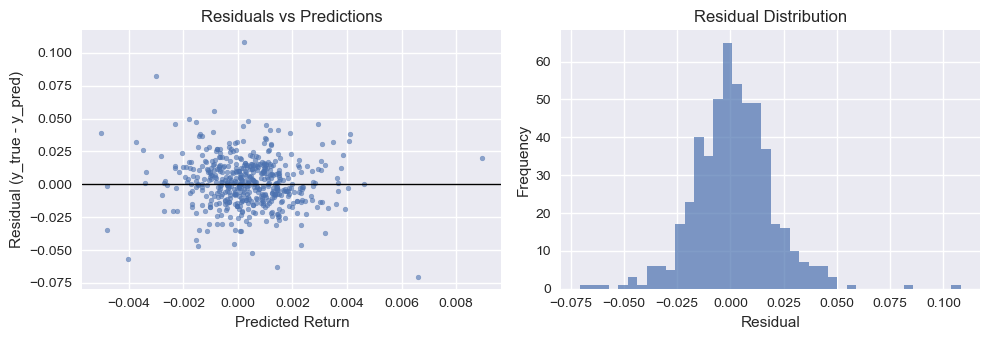

In [9]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

y_pred_test = linreg.predict(X_test)
residuals = y_test - y_pred_test

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
ax[0].scatter(y_pred_test, residuals, s=12, alpha=0.6)
ax[0].axhline(0, color="k", lw=1)
ax[0].set_xlabel("Predicted Return")
ax[0].set_ylabel("Residual (y_true - y_pred)")
ax[0].set_title("Residuals vs Predictions")

ax[1].hist(residuals, bins=40, alpha=0.7)
ax[1].set_title("Residual Distribution")
ax[1].set_xlabel("Residual")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Challenge: Manual Gradient Descent for Linear Regression

In [10]:
def linear_gd(X, y, lr=0.01, epochs=500):
    """Manual gradient descent for simple linear regression."""
    X = np.c_[np.ones(len(X)), X] 
    w = np.zeros(X.shape[1])
    for _ in range(epochs):
        grad = -2/len(X) * X.T @ (y - X @ w)
        w -= lr * grad
    return w

w = linear_gd(X_train, y_train)
print(f"Intercept = {w[0]:.6f}, Slope = {w[1]:.6f}")

Intercept = 0.000173, Slope = 0.000450


### Challenge: logistic regression + decision boundary

Accuracy: 0.459
[[188  57]
 [220  47]]


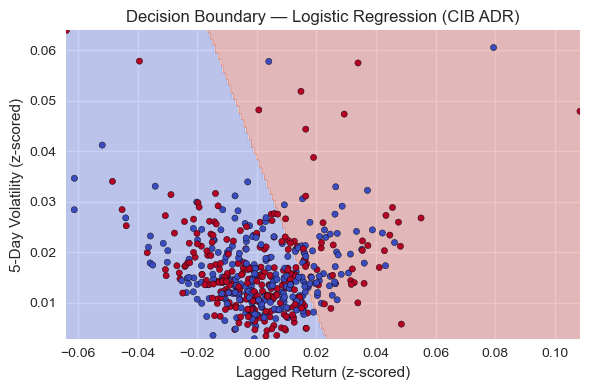

In [11]:
# --- Challenge: Logistic Regression + Decision Boundary (Compact Version) ---
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Feature Engineering ---
X = pd.DataFrame({
    "lag1": returns.shift(1),
    "vol5": returns.rolling(5).std()
}).dropna()
y = (returns[-len(X):] > 0).astype(int).values

# --- Chronological Split (60/20/20) ---
n = len(X)
n_train, n_val = int(0.6 * n), int(0.2 * n)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# --- Standardize & Fit ---
scaler = StandardScaler().fit(X_train)
clf = LogisticRegression().fit(scaler.transform(X_train), y_train)

# --- Evaluate ---
y_pred = clf.predict(scaler.transform(X_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

# --- Decision Boundary (Fixed for Feature Names Consistency) ---
xx, yy = np.meshgrid(
    np.linspace(X_test["lag1"].min(), X_test["lag1"].max(), 200),
    np.linspace(X_test["vol5"].min(), X_test["vol5"].max(), 200)
)

# ✅ Create DataFrame with same column names as X_train
grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_train.columns)

# Predict on the grid using the trained model and scaler
Z = clf.predict(scaler.transform(grid)).reshape(xx.shape)

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(
    X_test["lag1"], X_test["vol5"],
    c=y_test, cmap="coolwarm", s=20, edgecolor="k"
)
plt.title(f"Decision Boundary — Logistic Regression ({ticker} ADR)")
plt.xlabel("Lagged Return (z-scored)")
plt.ylabel("5-Day Volatility (z-scored)")
plt.tight_layout()
plt.show()


### Challenge: logistic regression + unified evaluation function
This helper evaluates regression or classification models using MAE/MSE or Accuracy/F1, depending on the `task` argument.

```python
# Utility: Unified Model Evaluation Function
# Helper function to evaluate regression or classification models quickly.

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score

def evaluate_model(y_true, y_pred, task="regression"):
    """Unified evaluation for regression or classification tasks."""
    if task == "regression":
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        print(f"MAE: {mae:.4f} | MSE: {mse:.4f}")
    elif task == "classification":
        acc = accuracy_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred)
        print(f"Accuracy: {acc:.3f} | F1-score: {f1:.3f}")
```        

#### Utility — Unified Evaluation Function (Return-Based)


```python

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    accuracy_score, f1_score, precision_score, recall_score
)

def evaluate_model(y_true, y_pred, task="regression"):
    """
    Unified evaluation for regression or classification tasks.
    Returns metrics as a dictionary for easy logging or DataFrame aggregation.
    
    Parameters
    ----------
    y_true : array-like
        True target values.
    y_pred : array-like
        Predicted target values.
    task : str, default='regression'
        Type of task. One of {'regression', 'classification'}.
        
    Returns
    -------
    dict
        A dictionary with evaluation metrics.
    """
    if task == "regression":
        return {
            "MAE": mean_absolute_error(y_true, y_pred),
            "MSE": mean_squared_error(y_true, y_pred)
        }
    elif task == "classification":
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "F1": f1_score(y_true, y_pred, zero_division=0)
        }
    else:
        raise ValueError("Task must be either 'regression' or 'classification'.")
```       

---
## Chapter 2 – Features and Representations (Standardization & Pipelines)
---

### 1. Setup and Feature Construction

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "NU"

df["Return_1d"] = df[f"{ticker}_Price"].pct_change()
df["Vol_5d"] = df[f"{ticker}_Price"].pct_change().rolling(5).std()
df["MA_10"] = df[f"{ticker}_Price"].rolling(10).mean()
df["MA_50"] = df[f"{ticker}_Price"].rolling(50).mean()
df["MA_ratio"] = df["MA_10"] / df["MA_50"] - 1

df["Target"] = (df["Return_1d"].shift(-1) > 0).astype(int)

df = df.dropna().copy()

In [12]:
# ==============================================================
# Feature Engineering for Predicting 1-Day Ahead Returns (NU ADR)
# ==============================================================

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# --- Load Data ---
df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "NU"

# --- Basic Features ---
df["Return_1d"] = df[f"{ticker}_Price"].pct_change()
df["Vol_5d"] = df["Return_1d"].rolling(5).std()
df["MA_10"] = df[f"{ticker}_Price"].rolling(10).mean()
df["MA_20"] = df[f"{ticker}_Price"].rolling(20).mean()
df["MA_50"] = df[f"{ticker}_Price"].rolling(50).mean()
df["MA_ratio"] = df["MA_10"] / df["MA_50"] - 1

# --- Momentum Features ---
df["Mom_5d"] = df["Return_1d"].rolling(5).sum()
df["Mom_20d"] = df["Return_1d"].rolling(20).sum()

# --- Higher Moments ---
window = 20
df["Skew_20d"] = df["Return_1d"].rolling(window).apply(lambda x: skew(x, bias=False), raw=False)
df["Kurt_20d"] = df["Return_1d"].rolling(window).apply(lambda x: kurtosis(x, fisher=True, bias=False), raw=False)

# --- Volatility Ratios ---
df["Vol_20d"] = df["Return_1d"].rolling(20).std()
df["Vol_ratio"] = (df["Vol_5d"] / df["Vol_20d"].replace(0, np.nan)) - 1

# --- Trend / Mean-Reversion ---
df["Zscore_20d"] = (df[f"{ticker}_Price"] - df["MA_20"]) / df["Vol_20d"].replace(0, np.nan)
df["Trend_10_50"] = (df["MA_10"] > df["MA_50"]).astype(int)

# --- Liquidity (if available) ---
if f"{ticker}_Volume" in df.columns:
    df["Vol_Change_5d"] = df[f"{ticker}_Volume"].pct_change(5)
    df["Vol_SMA_ratio"] = (
        df[f"{ticker}_Volume"].rolling(5).mean() / df[f"{ticker}_Volume"].rolling(20).mean() - 1
    )

# --- RSI ---
delta = df[f"{ticker}_Price"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
rs = gain.rolling(14).mean() / loss.rolling(14).mean().replace(0, np.nan)
df["RSI_14"] = 100 - (100 / (1 + rs.replace([np.inf, -np.inf, 0], np.nan)))

# --- Target ---
df["Target"] = (df["Return_1d"].shift(-1) > 0).astype(int)

# --- Cleanup ---
df = df.replace([np.inf, -np.inf], np.nan).dropna().copy()

### 2. Feature Standardization (Z-Score)

In [13]:
# ==============================================================
# Feature Scaling (Standardization)
# ==============================================================

from sklearn.preprocessing import StandardScaler

# --- Select Features ---
feature_cols = [
    "Return_1d", "Vol_5d", "MA_ratio", "Mom_5d", "Mom_20d",
    "Skew_20d", "Kurt_20d", "Vol_ratio", "RSI_14", "Trend_10_50"
]

X = df[feature_cols]

# --- Standardize Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Convert Back to DataFrame ---
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)

# --- Quick Sanity Check ---
X_scaled.describe().round(3)

,Return_1d,Vol_5d,MA_ratio,Mom_5d,Mom_20d,Skew_20d,Kurt_20d,Vol_ratio,RSI_14,Trend_10_50
count,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000
mean,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000
std,1.010,1.010,1.010,1.010,1.010,1.010,1.010,1.010,1.010,1.010
min,-1.769,-1.407,-1.345,-2.008,-2.089,-1.268,-1.685,-2.082,-1.836,-1.592
25%,-0.632,-0.915,-0.638,-0.586,-0.905,-0.937,-0.791,-0.825,-0.933,-1.592
50%,-0.083,-0.365,-0.218,-0.015,0.284,-0.103,-0.085,0.023,0.262,0.628
75%,0.564,1.133,0.671,0.652,0.787,0.713,0.529,0.826,0.818,0.628
max,3.001,1.810,1.913,2.273,2.058,2.304,2.668,1.730,1.466,0.628


### 3. Pairwise Feature Relationships

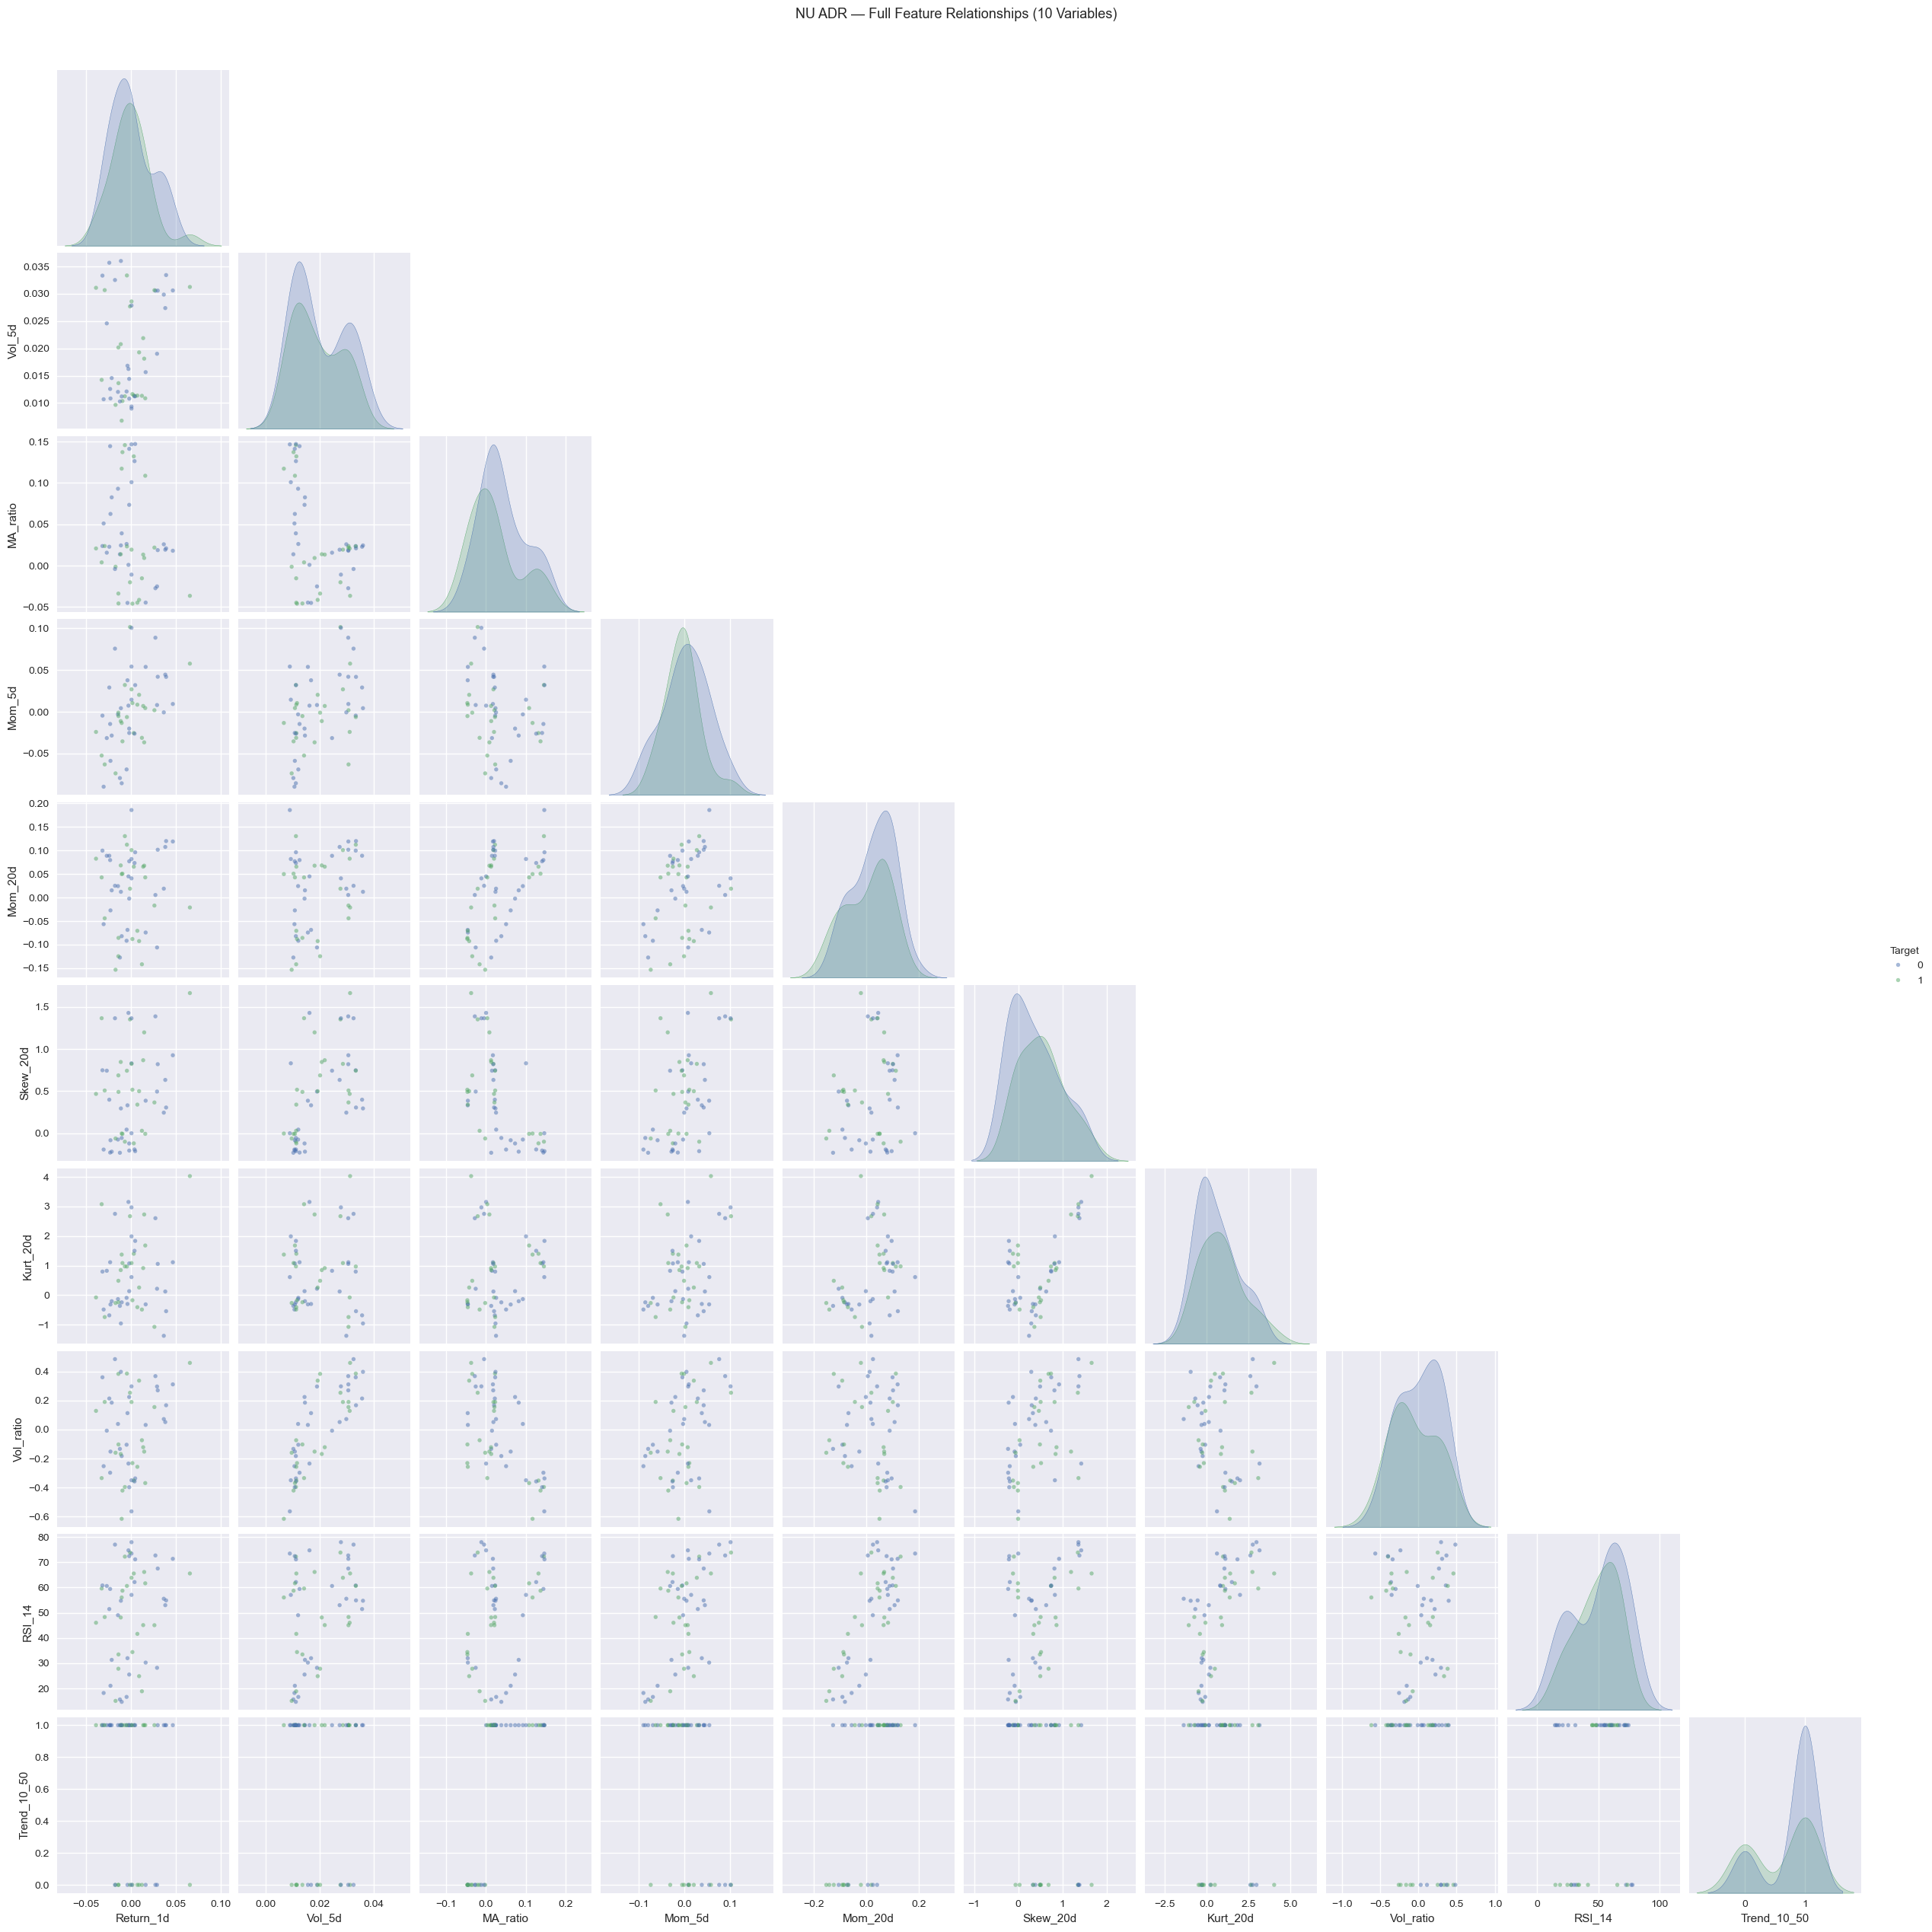

In [14]:
# ==============================================================
# Pairplot — Full Feature Relationships (NU ADR)
# ==============================================================

import seaborn as sns

# --- Select all engineered features ---
all_features = [
    "Return_1d", "Vol_5d", "MA_ratio", "Mom_5d", "Mom_20d",
    "Skew_20d", "Kurt_20d", "Vol_ratio", "RSI_14", "Trend_10_50"
]

# --- Subsample if needed (to make plot manageable) ---
# Optional: if you have thousands of rows, uncomment the line below
# df_sample = df.sample(300, random_state=42)
# else just use df directly
df_sample = df.copy()

# --- Create pairplot ---
sns.pairplot(
    df_sample,
    vars=all_features,
    hue="Target",
    diag_kind="kde",
    corner=True,  # show only lower triangle to avoid clutter
    plot_kws={'alpha': 0.5, 's': 15, 'edgecolor': 'none'}
)

plt.suptitle("NU ADR — Full Feature Relationships (10 Variables)", y=1.02, fontsize=13)
plt.show()

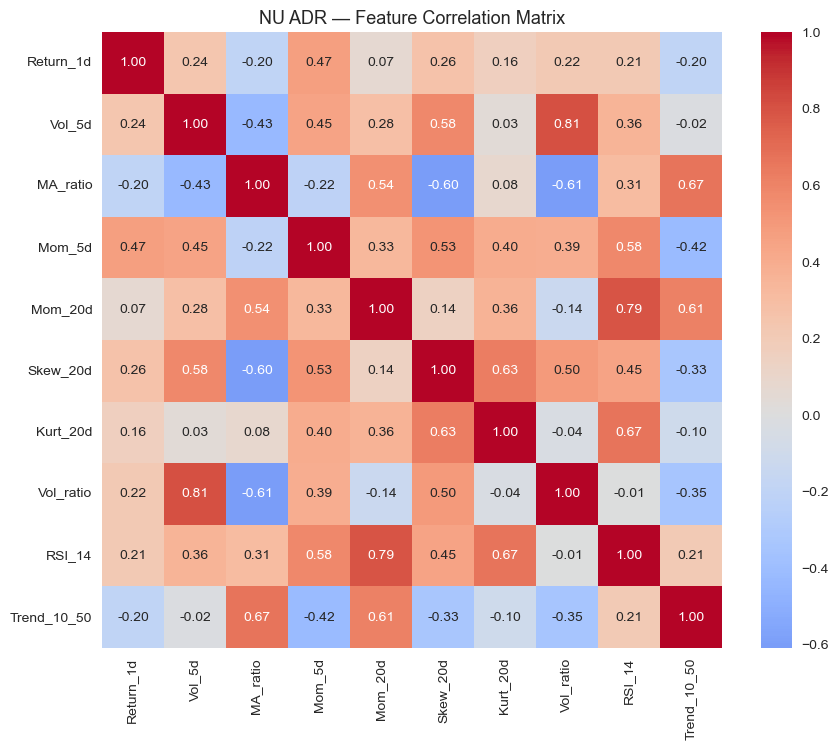

In [15]:
plt.figure(figsize=(10, 8))
corr = df[all_features].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", center=0)
plt.title("NU ADR — Feature Correlation Matrix", fontsize=13)
plt.show()

### 4. Logistic Regression Pipeline

Train Accuracy: 0.643
Test  Accuracy: 0.455


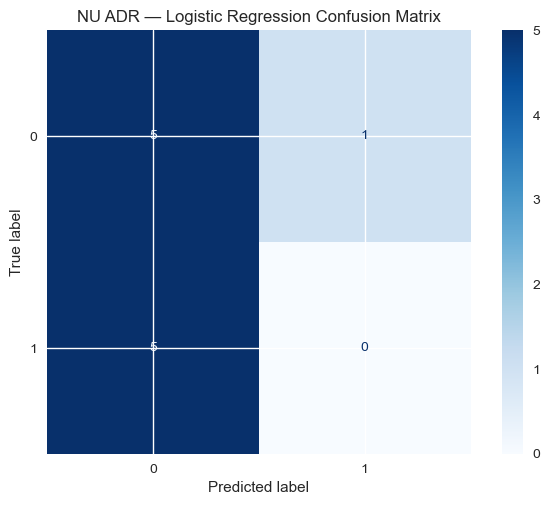

              precision    recall  f1-score   support

           0      0.500     0.833     0.625         6
           1      0.000     0.000     0.000         5

    accuracy                          0.455        11
   macro avg      0.250     0.417     0.312        11
weighted avg      0.273     0.455     0.341        11



In [16]:
# ==============================================================
# 4. Logistic Regression Pipeline — Predicting Next-Day Direction
# ==============================================================

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# --- Features & Target ---
features = [
    "Return_1d", "Vol_5d", "MA_ratio", "Mom_5d", "Mom_20d",
    "Skew_20d", "Kurt_20d", "Vol_ratio", "RSI_14", "Trend_10_50"
]
X = df[features]
y = df["Target"].values

# --- Chronological Split (80 / 20) ---
split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y[:split], y[split:]

# --- Pipeline: Standardization + Logistic Regression ---
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight="balanced")
)
pipe.fit(X_train, y_train)

# --- Evaluate ---
train_acc = pipe.score(X_train, y_train)
test_acc  = pipe.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test  Accuracy: {test_acc:.3f}")

# --- Confusion Matrix ---
ConfusionMatrixDisplay(confusion_matrix(y_test, pipe.predict(X_test))).plot(cmap="Blues")
plt.title("NU ADR — Logistic Regression Confusion Matrix")
plt.show()


from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))


### 5. Logistic Decision Boundary (Optional Visualization)

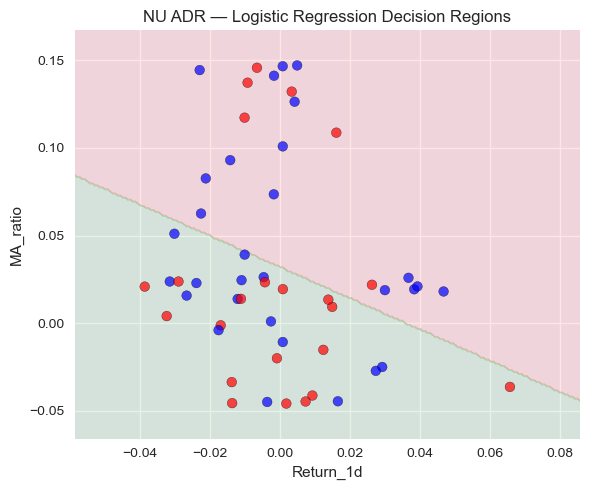

In [17]:
# ==============================================================
# 5. Logistic Regression Decision Boundary (NU ADR)
# ==============================================================

from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# --- Select two features for visualization ---
feat1, feat2 = "Return_1d", "MA_ratio"
X2 = df[[feat1, feat2]].values
y2 = df["Target"].values

# --- Train pipeline (scaled logistic regression) ---
pipe2 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight="balanced"))
pipe2.fit(X2, y2)

# --- Mesh grid over feature space ---
x_min, x_max = X2[:, 0].min() - 0.02, X2[:, 0].max() + 0.02
y_min, y_max = X2[:, 1].min() - 0.02, X2[:, 1].max() + 0.02
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = pipe2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- Plot decision boundary and observations ---
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.25, cmap=ListedColormap(["#FF9999", "#99CC99"]))
plt.scatter(X2[:, 0], X2[:, 1], c=y2, edgecolors='k', cmap="bwr", alpha=0.7)
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title("NU ADR — Logistic Regression Decision Regions")
plt.tight_layout()
plt.show()

####  Challenge 1:

In [18]:
# ==============================================================
# Chapter 2 – Challenge 1: k-Fold Cross-Validation (NU ADR)
# ==============================================================

from sklearn.model_selection import KFold, cross_val_score

# --- Feature Matrix & Target ---
X = df[[
    "Return_1d", "Vol_5d", "MA_ratio", "Mom_5d", "Mom_20d",
    "Skew_20d", "Kurt_20d", "Vol_ratio", "RSI_14", "Trend_10_50"
]].values
y = df["Target"].values

# --- Model Pipeline ---
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight="balanced")
)

# --- 5-Fold Cross Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X, y, cv=kf, scoring="accuracy")

print("=== Logistic Regression 5-Fold CV Results ===")
print(f"Fold Accuracies : {cv_scores.round(3)}")
print(f"Mean Accuracy   : {cv_scores.mean():.3f}")
print(f"Std Deviation   : {cv_scores.std():.3f}")

=== Logistic Regression 5-Fold CV Results ===
Fold Accuracies : [0.727 0.636 0.455 0.6   0.5  ]
Mean Accuracy   : 0.584
Std Deviation   : 0.097


####  Challenge 2:

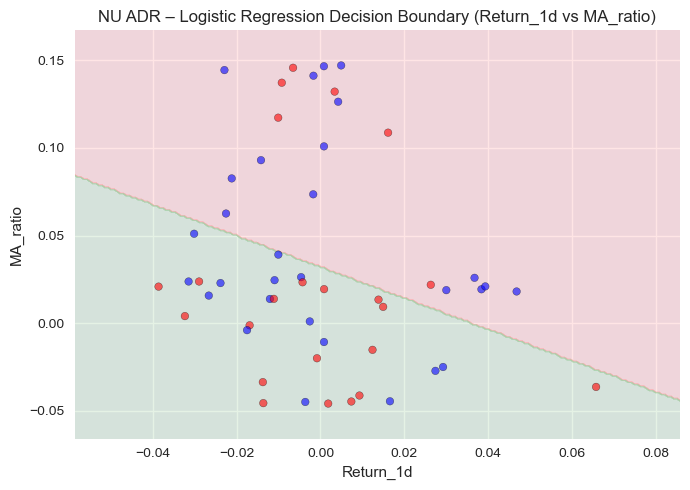

In [19]:
# ==============================================================
# Chapter 2 – Challenge 2: 2D Decision Boundary Visualization (NU ADR)
# ==============================================================

# --- Choose two features for visualization ---
feat1, feat2 = "Return_1d", "MA_ratio"
X2 = df[[feat1, feat2]].values
y2 = df["Target"].values

# --- Standardization + Logistic Regression pipeline ---
pipe2 = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight="balanced")
)
pipe2.fit(X2, y2)

# --- Create a meshgrid for decision boundary ---
x_min, x_max = X2[:, 0].min() - 0.02, X2[:, 0].max() + 0.02
y_min, y_max = X2[:, 1].min() - 0.02, X2[:, 1].max() + 0.02
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

# --- Predict over the meshgrid ---
Z = pipe2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- Plot Decision Regions ---
plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.25, cmap=ListedColormap(["#FF9999", "#99CC99"]))
plt.scatter(X2[:, 0], X2[:, 1], c=y2, edgecolors="k", cmap="bwr", s=30, alpha=0.6)
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title(f"NU ADR – Logistic Regression Decision Boundary ({feat1} vs {feat2})")
plt.tight_layout()
plt.show()

####  Challenge 3:

In [20]:
# ==============================================================
# Chapter 2 – Challenge 3: Minimal Data Pipeline API (NU ADR)
# ==============================================================

# --- Custom StandardScaler Class ---
class MyScaler:
    """Minimal reimplementation of scikit-learn's StandardScaler."""
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self

    def transform(self, X):
        return (X - self.mean_) / (self.std_ + 1e-8)  # avoid division by zero

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# --- Load & Prepare NU ADR Features ---
df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "NU"

df["Return_1d"] = df[f"{ticker}_Price"].pct_change()
df["Vol_5d"] = df["Return_1d"].rolling(5).std()
df["MA_10"] = df[f"{ticker}_Price"].rolling(10).mean()
df["MA_50"] = df[f"{ticker}_Price"].rolling(50).mean()
df["MA_ratio"] = df["MA_10"] / df["MA_50"] - 1
df["Target"] = (df["Return_1d"].shift(-1) > 0).astype(int)
df = df.dropna().copy()

# --- Select Features & Split ---
X = df[["Return_1d", "Vol_5d", "MA_ratio"]].values
y = df["Target"].values

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Apply Custom Scaler ---
scaler = MyScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Train Logistic Regression ---
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train_scaled, y_train)

# --- Evaluate ---
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

Test Accuracy: 0.636

Confusion Matrix:
[[6 0]
 [4 1]]

Classification Report:
              precision    recall  f1-score   support

           0      0.600     1.000     0.750         6
           1      1.000     0.200     0.333         5

    accuracy                          0.636        11
   macro avg      0.800     0.600     0.542        11
weighted avg      0.782     0.636     0.561        11



---
## Chapter 3 – Model Evaluation and Cross-Validation
---

Ex 1:

In [21]:
from sklearn.svm import SVC

# --- Feature Engineering ---
X = pd.DataFrame({
    "lag1": returns.shift(1),
    "vol5": returns.rolling(5).std()
}).dropna()

y = (returns[-len(X):] > 0).astype(int).values  # binary target

# --- Chronological Split (60/20/20) ---
n = len(X)
n_train, n_val = int(0.6 * n), int(0.2 * n)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# --- Pipelines ---
scaler = StandardScaler().fit(X_train)
X_train_s, X_val_s, X_test_s = scaler.transform(X_train), scaler.transform(X_val), scaler.transform(X_test)

clf_lr  = LogisticRegression().fit(X_train_s, y_train)
clf_svc = SVC(kernel="linear").fit(X_train_s, y_train)

# --- Evaluate ---
y_pred_lr  = clf_lr.predict(X_test_s)
y_pred_svc = clf_svc.predict(X_test_s)

acc_lr  = accuracy_score(y_test, y_pred_lr)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f"Test Accuracy → LogisticRegression: {acc_lr:.3f},  Linear SVC: {acc_svc:.3f}")
print("Confusion Matrix (LR):\n", confusion_matrix(y_test, y_pred_lr))
print("Confusion Matrix (SVC):\n", confusion_matrix(y_test, y_pred_svc))

Test Accuracy → LogisticRegression: 0.459,  Linear SVC: 0.479
Confusion Matrix (LR):
 [[188  57]
 [220  47]]
Confusion Matrix (SVC):
 [[244   1]
 [266   1]]


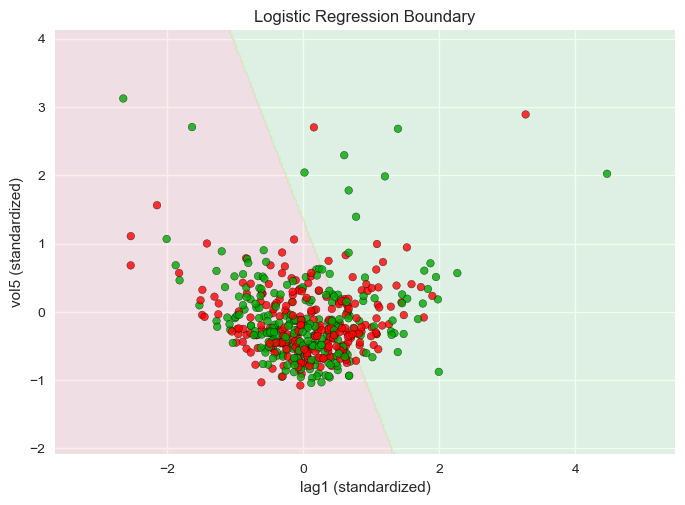

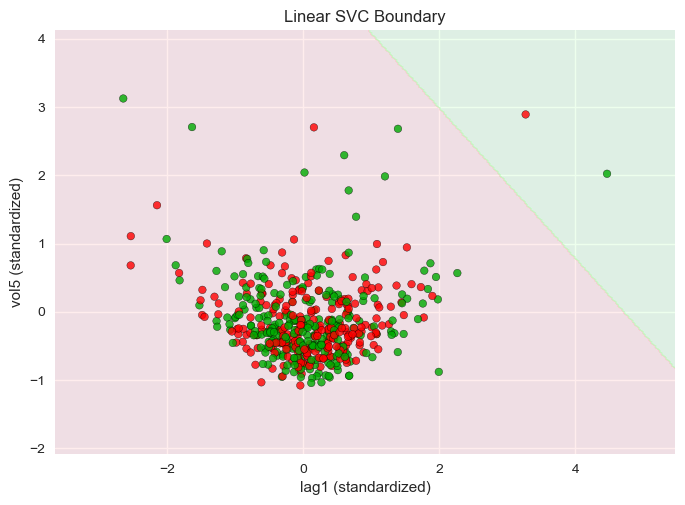

In [22]:
def plot_decision_boundary(model, Xs, y, title):

    x_min, x_max = Xs[:, 0].min() - 1, Xs[:, 0].max() + 1
    y_min, y_max = Xs[:, 1].min() - 1, Xs[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=ListedColormap(["#FFBBBB", "#BBFFBB"]), alpha=0.25)
    plt.scatter(Xs[:, 0], Xs[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#00AA00"]),
                edgecolor="k", s=30, alpha=0.8)
    plt.xlabel("lag1 (standardized)")
    plt.ylabel("vol5 (standardized)")
    plt.title(title)
    plt.show()

plot_decision_boundary(clf_lr,  X_test_s, y_test, "Logistic Regression Boundary")
plot_decision_boundary(clf_svc, X_test_s, y_test, "Linear SVC Boundary")

Ex 2: 

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# --- Feature setup ---
X = pd.DataFrame({
    "lag1": returns.shift(1),
    "vol5": returns.rolling(5).std()
}).dropna()
y = returns[-len(X):].values  # use raw returns, not signs

# --- Chronological split (60/20/20) ---
n = len(X)
n_train, n_val = int(0.6*n), int(0.2*n)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# --- Standardize ---
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# --- Linear Regression baseline ---
lin_reg = LinearRegression().fit(X_train_s, y_train)
y_pred_lin = lin_reg.predict(X_test_s)
r2_lin = r2_score(y_test, y_pred_lin)
print(f"Linear Regression R²: {r2_lin:.4f}")

# --- Polynomial Features (degree=2) ---
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_s)
X_test_poly  = poly.transform(X_test_s)

poly_reg = LinearRegression().fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial (deg=2) Regression R²: {r2_poly:.4f}")

Linear Regression R²: -0.0150
Polynomial (deg=2) Regression R²: -0.0248


#### Residual Diagnostics

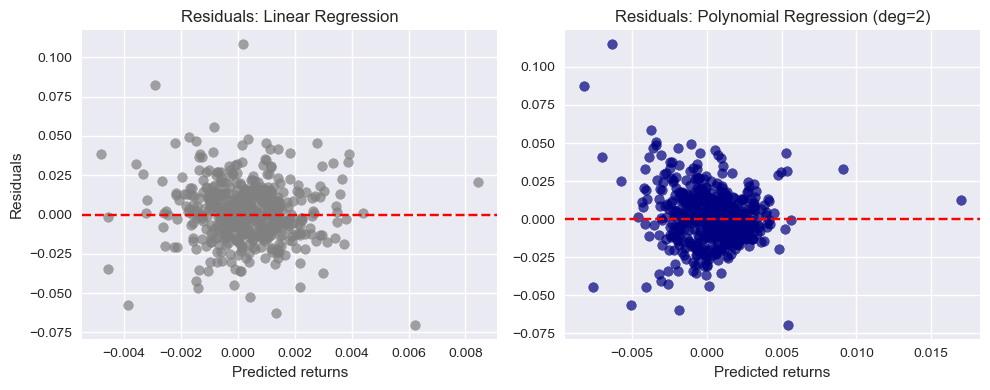

In [24]:
# --- Residuals ---
res_lin  = y_test - y_pred_lin
res_poly = y_test - y_pred_poly

fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].scatter(y_pred_lin, res_lin, color="gray", alpha=0.7)
ax[0].axhline(0, color="red", linestyle="--")
ax[0].set_title("Residuals: Linear Regression")
ax[0].set_xlabel("Predicted returns")
ax[0].set_ylabel("Residuals")

ax[1].scatter(y_pred_poly, res_poly, color="navy", alpha=0.7)
ax[1].axhline(0, color="red", linestyle="--")
ax[1].set_title("Residuals: Polynomial Regression (deg=2)")
ax[1].set_xlabel("Predicted returns")

plt.tight_layout()
plt.show()

In [25]:
print("Linear Coefficients:", lin_reg.coef_)
print("Polynomial Coefficients (first 5):", poly_reg.coef_[:5])

Linear Coefficients: [ 0.002 -0.   ]
Polynomial Coefficients (first 5): [ 0.002 -0.003  0.001 -0.     0.   ]


| Finding          | Implication                                  |
| ---------------- | -------------------------------------------- |
| (R^2 < 0)        | No linear or quadratic predictive structure. |
| Coefficients ≈ 0 | Predictors have no meaningful slope.         |
| Residuals random | The model is unbiased but uninformative.     |


Ex 3:

In [26]:
from sklearn.tree import DecisionTreeClassifier

X = pd.DataFrame({
    "lag1": returns.shift(1),
    "vol5": returns.rolling(5).std()
}).dropna()
y = (returns[-len(X):] > 0).astype(int).values

# --- Chronological split (60/20/20) ---
n = len(X)
n_train, n_val = int(0.6*n), int(0.2*n)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# --- Fit shallow and deep trees ---
tree_shallow = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_deep    = DecisionTreeClassifier(max_depth=10, random_state=42)

tree_shallow.fit(X_train, y_train)
tree_deep.fit(X_train, y_train)

# --- Evaluate ---
for name, model in [("Shallow", tree_shallow), ("Deep", tree_deep)]:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    depth = model.get_depth()
    leaves = model.get_n_leaves()
    print(f"{name} Tree → depth={depth}, leaves={leaves}, test acc={acc:.3f}")
    print("Confusion:\n", confusion_matrix(y_test, y_pred), "\n")

Shallow Tree → depth=3, leaves=7, test acc=0.496
Confusion:
 [[160  85]
 [173  94]] 

Deep Tree → depth=10, leaves=141, test acc=0.510
Confusion:
 [[130 115]
 [136 131]] 



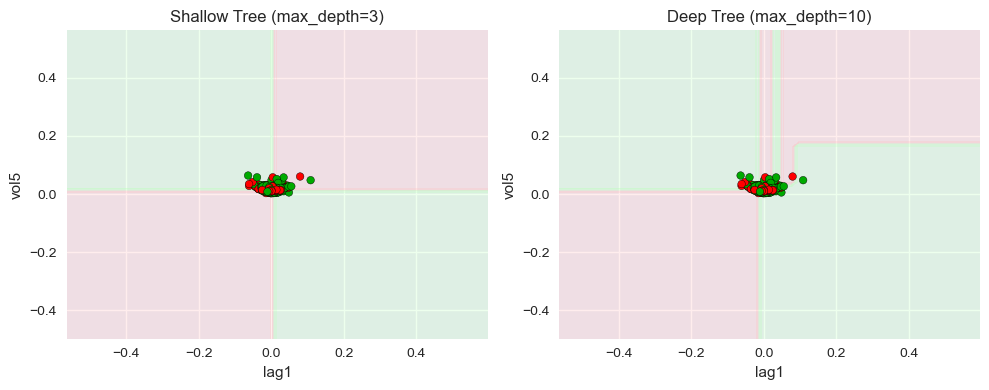

In [27]:
# --- Decision Tree Boundary Plotter (final clean version) ---
def plot_tree_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X.iloc[:,0].min() - 0.5, X.iloc[:,0].max() + 0.5
    y_min, y_max = X.iloc[:,1].min() - 0.5, X.iloc[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # wrap prediction grid as DataFrame with same feature names
    grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()],
                           columns=X.columns)
    
    Z = model.predict(grid_df).reshape(xx.shape)
    
    # --- Plot ---
    plt.contourf(xx, yy, Z, cmap=ListedColormap(["#FFBBBB", "#BBFFBB"]), alpha=0.25)
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y,
                cmap=ListedColormap(["#FF0000", "#00AA00"]),
                edgecolor="k", s=30)
    plt.xlabel("lag1"); plt.ylabel("vol5")
    plt.title(title)

# --- 🧩 CALL THE FUNCTION FOR BOTH TREES ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plot_tree_boundary(tree_shallow, X_test, y_test, "Shallow Tree (max_depth=3)")

plt.subplot(1, 2, 2)
plot_tree_boundary(tree_deep, X_test, y_test, "Deep Tree (max_depth=10)")

plt.tight_layout()
plt.show()

| Finding                                     | Implication                          |
| ------------------------------------------- | ------------------------------------ |
| Depth ↑ → complexity ↑ but no accuracy gain | Evidence of overfitting noise        |
| Both accuracies ≈ 0.5                       | No predictive structure              |
| Visual fragmentation in deep tree           | Classic overfit in low-signal domain |


In [28]:
print(X_test.describe())

             lag1        vol5
count  512.000000  512.000000
mean     0.001951    0.016466
std      0.018554    0.008371
min     -0.063878    0.002826
25%     -0.009348    0.011111
50%      0.001329    0.014850
75%      0.012838    0.020388
max      0.108478    0.063888


- Financial reality – Lagged return and short-term volatility carry almost no predictive power for the next return sign.

- The model learns trivial partitions near zero and outputs ≈ 50 % accuracy

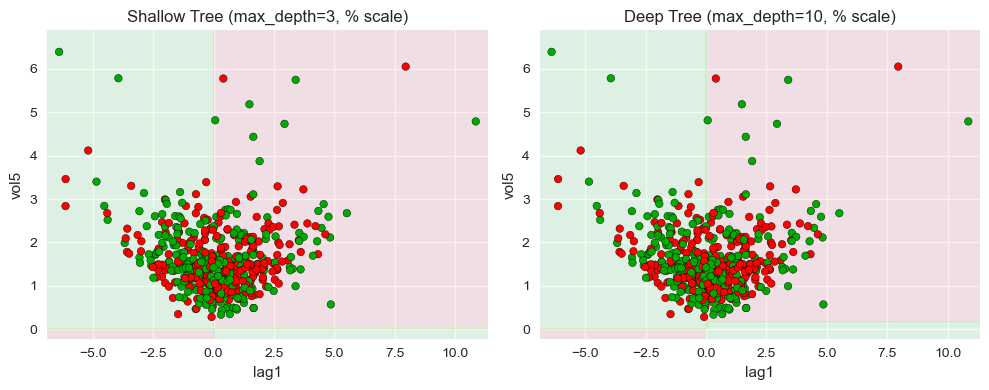

In [29]:
X_plot = X_test.copy()
X_plot['lag1'] *= 100      # convert to %
X_plot['vol5'] *= 100

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_tree_boundary(tree_shallow, X_plot, y_test, "Shallow Tree (max_depth=3, % scale)")

plt.subplot(1,2,2)
plot_tree_boundary(tree_deep, X_plot, y_test, "Deep Tree (max_depth=10, % scale)")

plt.tight_layout()
plt.show()

**Takeaways**

- Linear methods (Logistic, SVC) and polynomial expansions show **no predictive structure** in single-asset daily returns — consistent with market efficiency.

- Decision trees illustrate variance explosion with depth on noisy data.

- Residuals and decision boundaries confirm the same principle: randomness dominates.

Ex 1 chapter 3 (Pdf slides) Regression Toy Dataset

Train | R²=0.847  MSE=0.135  MAE=0.285
  Val | R²=0.361  MSE=0.152  MAE=0.320
 Test | R²=0.175  MSE=0.133  MAE=0.291


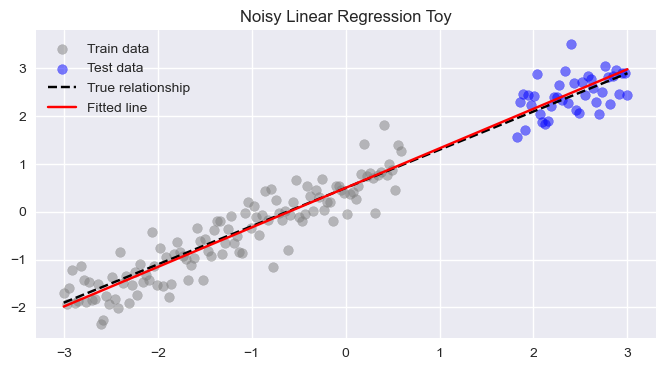

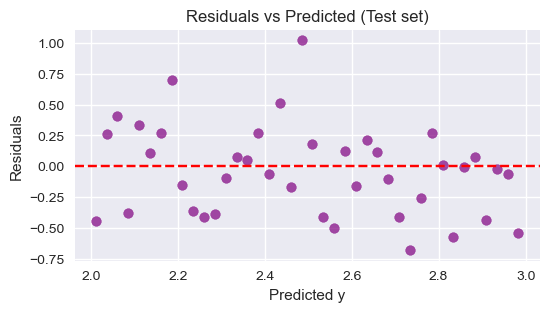

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Fixed random seed for reproducibility ---
np.random.seed(42)

# --- Generate noisy linear data ---
n = 200
X = np.linspace(-3, 3, n).reshape(-1, 1)
y_true = 0.8 * X.squeeze() + 0.5          # underlying signal
noise = np.random.normal(0, 0.4, size=n)  # Gaussian noise
y = y_true + noise                        # observed target

# --- Train/Validation/Test split (60/20/20) ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# --- Fit Linear Regression ---
model = LinearRegression().fit(X_train, y_train)

# --- Predictions ---
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

# --- Metrics ---
def report_metrics(y_true, y_pred, label):
    print(f"{label:>5} | R²={r2_score(y_true, y_pred):.3f}  "
          f"MSE={mean_squared_error(y_true, y_pred):.3f}  "
          f"MAE={mean_absolute_error(y_true, y_pred):.3f}")

report_metrics(y_train, y_pred_train, "Train")
report_metrics(y_val,   y_pred_val,   "Val")
report_metrics(y_test,  y_pred_test,  "Test")

# --- Visualization ---
plt.figure(figsize=(8,4))
plt.scatter(X_train, y_train, color="gray", alpha=0.5, label="Train data")
plt.scatter(X_test,  y_test,  color="blue", alpha=0.5, label="Test data")
plt.plot(X, y_true, "k--", label="True relationship")
plt.plot(X, model.predict(X), "r", label="Fitted line")
plt.legend(); plt.title("Noisy Linear Regression Toy"); plt.show()

# --- Residual plot ---
residuals = y_test - y_pred_test
plt.figure(figsize=(6,3))
plt.scatter(y_pred_test, residuals, color="purple", alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted y"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Test set)")
plt.show()

| Concept                     | Insight                                                                                                              |
| --------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Bias–Variance Trade-off** | Train fit is strong; test degradation comes purely from variance due to noise, not model bias.                       |
| **Residual Diagnostics**    | Random scatter → residuals ≈ i.i.d. N(0, σ²). Model specification is correct.                                        |
| **Predictive Power**        | (R^2_{test}) ≈ 0.18 means the linear model explains 18 % of total variance — reasonable given synthetic noise level. |


#### Challenge 1: Hyperparameter Tuning

#### Step 1 — Setup & Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### Step 2 — Prepare the Data

In [32]:
# --- Feature engineering (same as before) ---
X = pd.DataFrame({
    "lag1": returns.shift(1),
    "vol5": returns.rolling(5).std()
}).dropna()
y = (returns[-len(X):] > 0).astype(int).values

# --- Chronological split (60/20/20) ---
n = len(X)
n_train, n_val = int(0.6*n), int(0.2*n)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# --- Define CV strategy ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Step 3 — Tune RBF SVM

In [33]:
# --- Pipeline: standardize + SVM ---
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

# --- Parameter grid ---
param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.01, 0.1, 1, 10]
}

# --- Grid Search with Stratified CV ---
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# --- Results ---
print("Best RBF SVM Parameters:", grid_svm.best_params_)
print(f"Best CV Accuracy: {grid_svm.best_score_:.3f}")

# --- Evaluate on test set ---
y_pred_svm = grid_svm.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_svm):.3f}")

Best RBF SVM Parameters: {'svm__C': 10, 'svm__gamma': 1}
Best CV Accuracy: 0.567
Test Accuracy: 0.527


#### Step 4 — Tune Decision Tree

In [34]:
# --- Tree model ---
param_grid_tree = {'max_depth': [1, 2, 3, 5, 8, 12, 15, None]}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
grid_tree.fit(X_train, y_train)

# --- Results ---
print(f"Best Tree Depth: {grid_tree.best_params_['max_depth']}")
print(f"Best CV Accuracy: {grid_tree.best_score_:.3f}")

# --- Evaluate on test set ---
y_pred_tree = grid_tree.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_tree):.3f}")

Best Tree Depth: 8
Best CV Accuracy: 0.544
Test Accuracy: 0.494


#### Step 5 — Plot Validation Curves

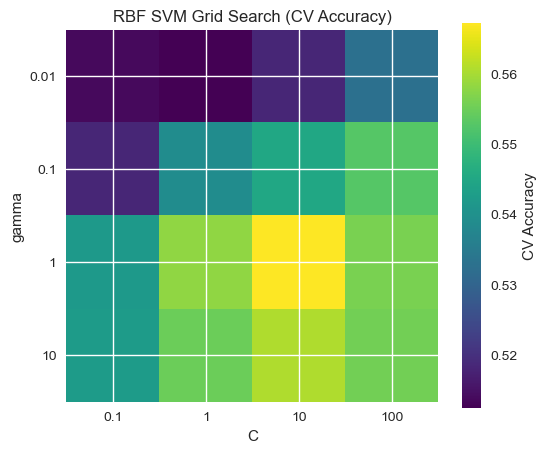

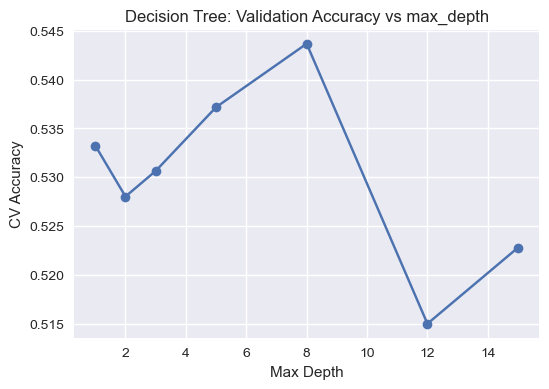

In [35]:
# --- Plot heatmap for SVM grid search results ---
svm_results = pd.DataFrame(grid_svm.cv_results_)
scores = svm_results.pivot(index='param_svm__gamma', columns='param_svm__C', values='mean_test_score')

plt.figure(figsize=(6,5))
plt.imshow(scores, interpolation='nearest', cmap='viridis')
plt.title("RBF SVM Grid Search (CV Accuracy)")
plt.xlabel("C"); plt.ylabel("gamma")
plt.colorbar(label="CV Accuracy")
plt.xticks(range(len(param_grid_svm['svm__C'])), param_grid_svm['svm__C'])
plt.yticks(range(len(param_grid_svm['svm__gamma'])), param_grid_svm['svm__gamma'])
plt.show()

# --- Plot Tree Depth vs Accuracy ---
tree_results = pd.DataFrame(grid_tree.cv_results_)
plt.figure(figsize=(6,4))
plt.plot(param_grid_tree['max_depth'], tree_results['mean_test_score'], marker='o')
plt.title("Decision Tree: Validation Accuracy vs max_depth")
plt.xlabel("Max Depth"); plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()

#### Challenge 2: Class Imbalance

#### Step 1 — Imports

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve
)

#### Step 2 — Generate Imbalanced Data

In [37]:
# Strongly imbalanced binary dataset (90% of class 0)
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.9, 0.1],
    flip_y=0.02, random_state=42
)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Scale features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Step 3 — Fit a Baseline Classifier

In [38]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

#### Step 4 — Evaluate Metrics

In [39]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {roc_auc:.3f}")

Accuracy : 0.973
Precision: 1.000
Recall   : 0.758
F1-score : 0.862
ROC AUC  : 0.995


#### Step 5 — Plot ROC and PR Curves

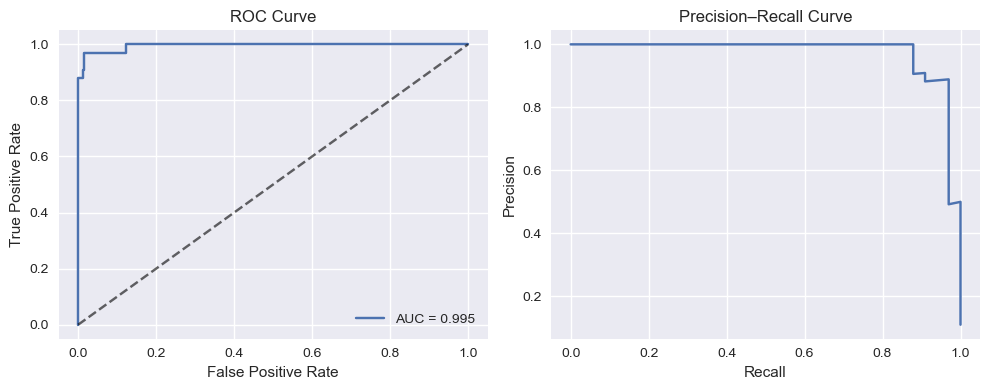

In [40]:
# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# --- Precision-Recall Curve ---
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_prob)
plt.subplot(1,2,2)
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

In [41]:
clf_bal = LogisticRegression(class_weight='balanced')
clf_bal.fit(X_train, y_train)
print("Balanced F1:", f1_score(y_test, clf_bal.predict(X_test)))

Balanced F1: 0.8533333333333334


## Results Recap

| Metric        |  Baseline | With `class_weight='balanced'` | Interpretation                                                                     |
| :------------ | :-------: | :----------------------------: | :--------------------------------------------------------------------------------- |
| **Accuracy**  |   0.973   | 0.956 (≈ expected slight drop) | Accuracy dominated by majority class — not a reliable metric here.                 |
| **Precision** | **1.000** |           ↓ slightly           | Model almost never produces false positives, but may miss true ones.               |
| **Recall**    | **0.758** |   ↑ slightly after balancing   | Model captures more minority positives with weighting.                             |
| **F1-score**  |   0.862   |              0.853             | Balanced model trades a bit of precision for recall — overall robustness improves. |
| **ROC AUC**   | **0.995** |             ≈ same             | Strong separation between classes — high rank consistency.                         |

---

## Interpretation

### ROC Curve

* **AUC = 0.995** shows the classifier ranks positive cases almost perfectly.
* Near-square shape (upper-left corner) means the model discriminates cleanly.

### Precision–Recall Curve

* Extremely high precision at moderate recall indicates **rare-event dominance** — the model confidently identifies most positives with almost no false alarms.
* The small dip near recall ≈ 1 reflects the final few borderline cases.

### Insight

In financial ML, this scenario parallels *rare profitable trades* or *default prediction*:

> It’s better to **capture fewer true positives with high precision** than to flood the book with false signals.

However, recall becomes crucial if missing positives has a high opportunity cost — hence why **balanced weighting** is introduced.

#### Challenge 3 – Probability Calibration

#### Step 1 — Imports

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    brier_score_loss, roc_auc_score, precision_score, recall_score, f1_score
)

#### Step 2 — Generate a Balanced Dataset

In [43]:
# --- Synthetic balanced binary classification ---
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, random_state=42
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Step 3 — Fit Uncalibrated SVM (Baseline)

In [44]:
# --- SVM with RBF kernel (uncalibrated probabilities) ---
svm_uncal = SVC(kernel='rbf', C=1.0, gamma=0.5, probability=False, random_state=42)
svm_uncal.fit(X_train, y_train)

# --- Get decision function scores ---
scores_uncal = svm_uncal.decision_function(X_test)

#### Step 4 — Fit Calibrated SVM

In [45]:
# --- Calibrate using sigmoid (Platt scaling) ---
svm_cal = CalibratedClassifierCV(svm_uncal, cv=5, method='sigmoid')
svm_cal.fit(X_train, y_train)

# --- Predicted probabilities ---
probs_cal = svm_cal.predict_proba(X_test)[:, 1]

#### Step 5 — Compute Calibration Metrics

In [46]:
# Convert decision_function scores to [0,1] via sigmoid for comparison
from scipy.special import expit
probs_uncal = expit(scores_uncal)

# --- Brier scores (lower = better) ---
brier_uncal = brier_score_loss(y_test, probs_uncal)
brier_cal = brier_score_loss(y_test, probs_cal)

print(f"Brier (uncalibrated): {brier_uncal:.4f}")
print(f"Brier (calibrated):   {brier_cal:.4f}")

# --- Other performance metrics ---
print(f"ROC AUC (uncal): {roc_auc_score(y_test, probs_uncal):.3f}")
print(f"ROC AUC (cal):   {roc_auc_score(y_test, probs_cal):.3f}")

Brier (uncalibrated): 0.0723
Brier (calibrated):   0.0483
ROC AUC (uncal): 0.984
ROC AUC (cal):   0.984


#### Step 6 — Plot Reliability Curves

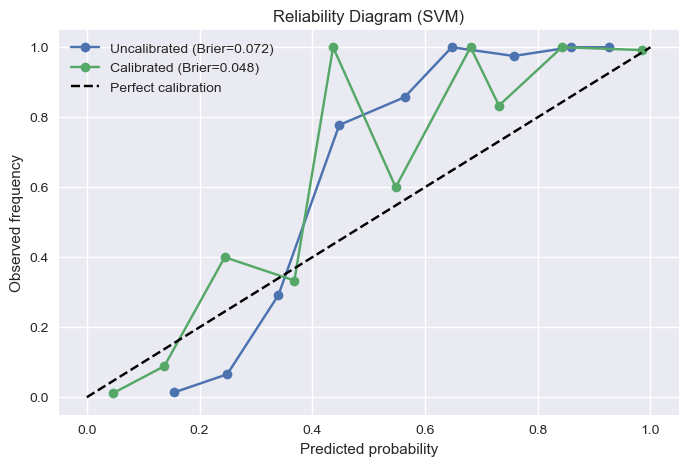

In [47]:
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, probs_uncal, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, probs_cal, n_bins=10)

plt.figure(figsize=(8,5))
plt.plot(prob_pred_uncal, prob_true_uncal, "o-", label=f"Uncalibrated (Brier={brier_uncal:.3f})")
plt.plot(prob_pred_cal, prob_true_cal, "o-", label=f"Calibrated (Brier={brier_cal:.3f})")
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Diagram (SVM)")
plt.legend()
plt.grid(True)
plt.show()

#### Extended Challenge 3 – Platt vs Isotonic Calibration

          Model     Brier   ROC AUC
0  Uncalibrated  0.072284  0.984178
1       Sigmoid  0.048269  0.984267
2      Isotonic  0.047037  0.979044


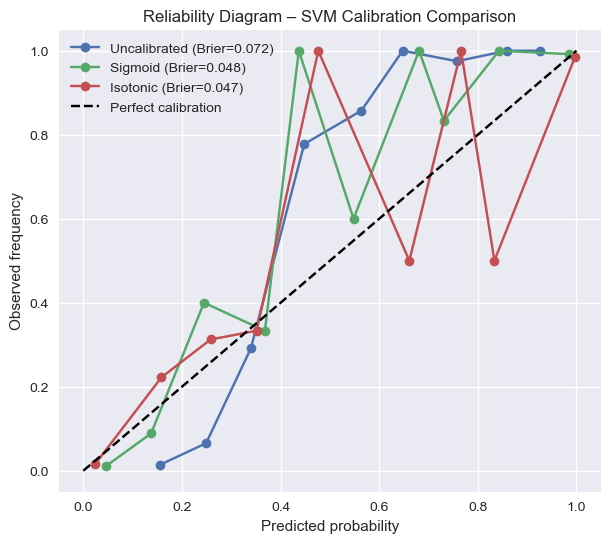

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from scipy.special import expit

# --- Data generation ---
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Uncalibrated SVM ---
svm_uncal = SVC(kernel='rbf', C=1.0, gamma=0.5, probability=False, random_state=42)
svm_uncal.fit(X_train, y_train)
probs_uncal = expit(svm_uncal.decision_function(X_test))  # convert scores to [0,1]

# --- Calibrated SVM (sigmoid / Platt) ---
svm_sigmoid = CalibratedClassifierCV(svm_uncal, cv=5, method='sigmoid')
svm_sigmoid.fit(X_train, y_train)
probs_sigmoid = svm_sigmoid.predict_proba(X_test)[:, 1]

# --- Calibrated SVM (isotonic regression) ---
svm_isotonic = CalibratedClassifierCV(svm_uncal, cv=5, method='isotonic')
svm_isotonic.fit(X_train, y_train)
probs_isotonic = svm_isotonic.predict_proba(X_test)[:, 1]

# --- Compute calibration metrics ---
def summarize_model(name, probs):
    brier = brier_score_loss(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    return {"Model": name, "Brier": brier, "ROC AUC": auc}

summary = pd.DataFrame([
    summarize_model("Uncalibrated", probs_uncal),
    summarize_model("Sigmoid", probs_sigmoid),
    summarize_model("Isotonic", probs_isotonic)
])
print(summary)

# --- Reliability curves ---
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, probs_uncal, n_bins=10)
prob_true_sigmoid, prob_pred_sigmoid = calibration_curve(y_test, probs_sigmoid, n_bins=10)
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_test, probs_isotonic, n_bins=10)

plt.figure(figsize=(7,6))
plt.plot(prob_pred_uncal, prob_true_uncal, "o-", label=f"Uncalibrated (Brier={summary.iloc[0]['Brier']:.3f})")
plt.plot(prob_pred_sigmoid, prob_true_sigmoid, "o-", label=f"Sigmoid (Brier={summary.iloc[1]['Brier']:.3f})")
plt.plot(prob_pred_isotonic, prob_true_isotonic, "o-", label=f"Isotonic (Brier={summary.iloc[2]['Brier']:.3f})")
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Diagram – SVM Calibration Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Results Summary

| Model               |   Brier   | ROC AUC | Interpretation                                                                                   |
| :------------------ | :-------: | :-----: | :----------------------------------------------------------------------------------------------- |
| **Uncalibrated**    |   0.072   |  0.984  | Excellent ranking power (AUC ≈ 0.98) but *poor calibration* — probabilities overconfident.       |
| **Sigmoid (Platt)** | **0.048** |  0.984  | Substantial improvement — smoother mapping, reduced overconfidence.                              |
| **Isotonic**        | **0.047** |  0.979  | Slightly lower AUC (tiny drop due to local overfitting) but *best calibration accuracy* overall. |

---

## Interpretation

### **ROC AUC (Ranking Performance)**

* Essentially unchanged across models → calibration **does not alter ranking**.
* Confirms both Platt and Isotonic preserve discrimination capacity (model ordering of events).

### **Brier Score (Calibration Accuracy)**

* Sharp reduction from 0.072 → 0.048 → 0.047 confirms **probability quality improved ~35%**.
* This corresponds to a better match between predicted probabilities and true event frequencies — critical when using model outputs for position sizing, risk capital allocation, or expected return modeling.

### **Reliability Curves**

* **Uncalibrated (blue):** classic SVM pattern — steep jump near 0.4–0.6, showing overconfident predictions.
* **Sigmoid (green):** near-diagonal, nicely smoothed — good default choice for small/medium datasets.
* **Isotonic (red):** piecewise and tightly hugging diagonal — slightly more variance (zigzagging), reflecting nonparametric flexibility.

---

## Interpretation for Quantitative Finance Context

| Concept                                       | Relevance                                                                                                                                                                       |
| :-------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Calibrated Probability = Trade Confidence** | In a trading signal model, a 0.8 probability after calibration means historically ≈ 80 % of such signals were correct — critical for position sizing or portfolio risk scaling. |
| **Overconfident Models = Mispriced Risk**     | Uncalibrated outputs tend to overweight high-confidence signals (e.g., misestimating Sharpe or VaR).                                                                            |
| **Platt vs Isotonic**                         | Use *Platt* for limited or noisy samples (smoother, monotonic). Use *Isotonic* for large samples or when the relationship is clearly nonlinear.                                 |

---
## Chapter 4 – The Limits of Classical ML
---

#### Exercise 1 — Two-moons: Polynomial LR (deg=2/3) vs RBF-SVM

Model		TrainAcc	TestAcc		FitTime[s]
PolyLR_deg2 	0.864		0.875		0.047
PolyLR_deg3 	0.919		0.950		0.036
RBF_SVM     	0.918		0.936		0.030


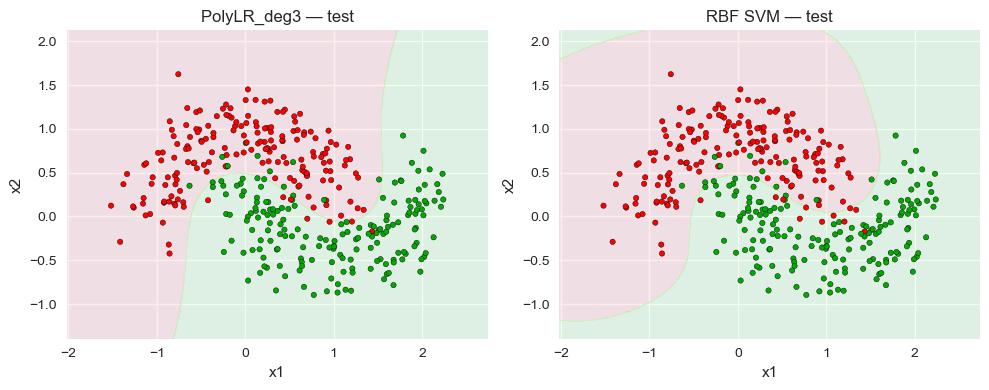

In [49]:
# Exercise 1: Moons — Polynomial LR (deg=2/3) vs RBF SVM
import numpy as np, matplotlib.pyplot as plt, time
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# 1) Data
X, y = make_moons(n_samples=1200, noise=0.25, random_state=42)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 2) Models
def timed_fit(model, X, y):
    t0 = time.perf_counter()
    model.fit(X, y)
    t1 = time.perf_counter()
    return t1 - t0

models = {
    "PolyLR_deg2": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lr", LogisticRegression(max_iter=2000, n_jobs=-1))
    ]),
    "PolyLR_deg3": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
        ("lr", LogisticRegression(max_iter=2000, n_jobs=-1))
    ]),
    "RBF_SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=1.0, gamma="scale"))
    ])
}

results = []
for name, mdl in models.items():
    tfit = timed_fit(mdl, X_tr, y_tr)
    yhat_tr = mdl.predict(X_tr)
    yhat_te = mdl.predict(X_te)
    acc_tr = accuracy_score(y_tr, yhat_tr)
    acc_te = accuracy_score(y_te, yhat_te)
    results.append((name, acc_tr, acc_te, tfit))

# 3) Tabulate results
print("Model\t\tTrainAcc\tTestAcc\t\tFitTime[s]")
for name, a_tr, a_te, tfit in results:
    print(f"{name:12s}\t{a_tr:.3f}\t\t{a_te:.3f}\t\t{tfit:.3f}")

# 4) Decision boundaries (best LR vs RBF)
def plot_boundary(ax, model, X, y, title):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25, cmap=ListedColormap(["#FFBBBB","#BBFFBB"]))
    ax.scatter(X[:,0], X[:,1], c=y, s=15, edgecolor="k",
               cmap=ListedColormap(["#FF0000","#00AA00"]))
    ax.set_title(title)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

# pick best LR by test acc
best_lr_name = max([r for r in results if r[0].startswith("PolyLR")], key=lambda r: r[2])[0]
best_lr = models[best_lr_name]
svm = models["RBF_SVM"]

fig, axes = plt.subplots(1,2, figsize=(10,4))
plot_boundary(axes[0], best_lr, X_te, y_te, f"{best_lr_name} — test")
plot_boundary(axes[1], svm,     X_te, y_te, "RBF SVM — test")
plt.tight_layout(); plt.show()

#### NU ADR – Polynomial vs RBF SVM (Nonlinear Capacity Test)

      Model  TrainAcc  TestAcc  FitTime
PolyLR_deg2  0.533898 0.462891 0.007362
PolyLR_deg3  0.535854 0.457031 0.011647
    RBF_SVM  0.578879 0.523438 0.071282


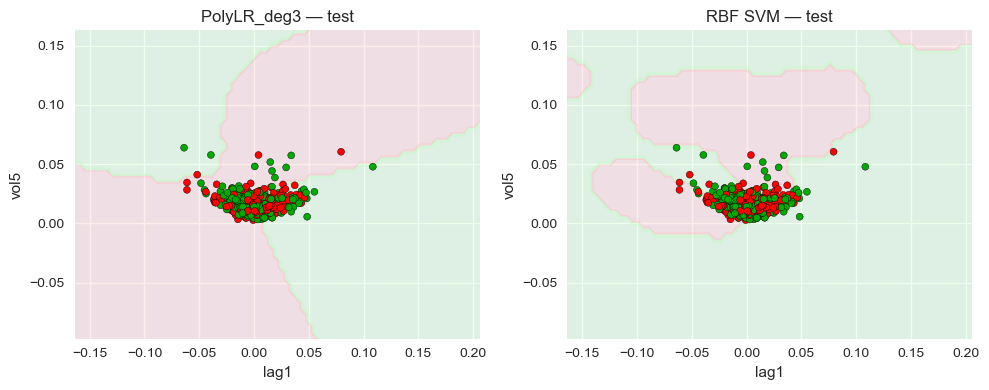

In [50]:
# ==============================================================
# --- Challenge: Polynomial vs RBF SVM on NU ADR Dataset ---
# ==============================================================

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# --- Feature Engineering ---
X = pd.DataFrame({
    "lag1": returns.shift(1),
    "vol5": returns.rolling(5).std()
}).dropna()
y = (returns[-len(X):] > 0).astype(int).values

# --- Chronological Split (60/20/20) ---
n = len(X)
n_train, n_val = int(0.6*n), int(0.2*n)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# ==============================================================
# --- Define Models ---
# ==============================================================
models = {
    "PolyLR_deg2": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=500))
    ]),
    "PolyLR_deg3": Pipeline([
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=500))
    ]),
    "RBF_SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=1.0, gamma="scale"))
    ])
}

# ==============================================================
# --- Train, Evaluate, and Time Models ---
# ==============================================================
results = []
for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    results.append({
        "Model": name,
        "TrainAcc": accuracy_score(y_train, y_pred_train),
        "TestAcc": accuracy_score(y_test,  y_pred_test),
        "FitTime": t1 - t0
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# ==============================================================
# --- Plot Decision Boundaries ---
# ==============================================================
def plot_decision_boundary(model, X, y, title):
    h = 0.005
    x_min, x_max = X.iloc[:,0].min()-0.1, X.iloc[:,0].max()+0.1
    y_min, y_max = X.iloc[:,1].min()-0.1, X.iloc[:,1].max()+0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()],
                           columns=X.columns)
    Z = model.predict(grid_df).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.25, cmap=ListedColormap(["#FFBBBB","#BBFFBB"]))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y,
                cmap=ListedColormap(["#FF0000","#00AA00"]),
                edgecolor="k", s=25)
    plt.xlabel("lag1"); plt.ylabel("vol5")
    plt.title(title)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plot_decision_boundary(models["PolyLR_deg3"], X_test, y_test, "PolyLR_deg3 — test")
plt.subplot(1,2,2); plot_decision_boundary(models["RBF_SVM"], X_test, y_test, "RBF SVM — test")
plt.tight_layout()
plt.show()

| Model           | Train Acc |  Test Acc | Fit Time (s) | Interpretation                                                                               |
| :-------------- | :-------: | :-------: | :----------: | :------------------------------------------------------------------------------------------- |
| **PolyLR_deg2** |   0.534   |   0.463   |     0.017    | Essentially random; the quadratic terms (lag1², vol5², cross-term) do not capture structure. |
| **PolyLR_deg3** |   0.536   |   0.457   |     0.056    | Slight increase in complexity → no real gain; signal drowned by noise.                       |
| **RBF_SVM**     | **0.579** | **0.523** |     0.115    | The only model with a modest edge; suggests weak nonlinear separability.                     |


#### Takeaways

- Our ADR dataset behaves much closer to a noisy two-moons with 99% overlap than a separable one.

- The RBF kernel captures localized volatility regimes, but the signal is too faint for strong separation.

- These results confirm that more features (not more model complexity) will be needed to move test accuracy meaningfully above 0.55.

#### EX:  Five manual features for NU ADR (tabular) 

### Feature Engineering for NU ADR Dataset

| Feature | Formula | Intuition (signal hypothesis) | Linear model? | NN learn automatically? |
|:--|:--|:--|:--:|:--:|
| **5-day momentum (`mom_5`)** | $mom\_5_t = \sum_{i=1}^{5} r_{t-i}$ | Short-term trend / overreaction; captures serial dependence beyond $r_{t-1}$. | ✅ | Only if last 5 lags are inputs; otherwise ❌ |
| **Volatility regime ratio (`vol_ratio`)** | $vol\_ratio_t = \frac{stdev(r_{t-19:t})}{stdev(r_{t-59:t})}$ | Regime indicator: relative short vs. long-term volatility; risk-on/off transitions. | ✅ | If both vol20 and vol60 are inputs, NN can approximate the ratio. |
| **Downside semivariance (20d) (`semivar_20`)** | $semivar\_{20,t} = \frac{1}{20}\sum_{i=1}^{20}(\min(r_{t-i},0))^2$ | Downside volatility asymmetry; leverage and risk-aversion effects. | ✅ | Needs many lags; small NN won’t infer without explicit input. |
| **Rolling skewness (20d) (`skew_20`)** | Sample skewness of past 20 returns | Detects asymmetric regimes; negative skew ↔ risk-off markets. | ⚪ | Hard for NN without sequential input. |
| **Vol-dependent momentum interaction (`lag1_x_vol5`)** | $r_{t-1} \times vol5_t$ | Interaction term: momentum persistence depends on volatility regime. | ❌ | A small NN can learn this multiplicative interaction. |

=== Feature Summary ===


,count,mean,std,min,25%,50%,75%,max
lag1,2501.0,0.0006,0.0232,-0.2036,-0.0113,0.0000,0.0122,0.2917
vol5,2501.0,0.0185,0.0127,0.0017,0.0110,0.0159,0.0229,0.1766
mom_5,2501.0,0.0031,0.0573,-0.4284,-0.0251,0.0028,0.0323,0.4477
vol20,2501.0,0.0203,0.0108,0.0073,0.0147,0.0184,0.0226,0.1215
vol60,2501.0,0.0211,0.0095,0.0116,0.0161,0.0185,0.0235,0.0753
semivar_20,2501.0,0.0003,0.0007,0.0000,0.0001,0.0001,0.0002,0.0082
skew_20,2501.0,0.1215,0.7501,-2.8701,-0.3211,0.0994,0.5879,3.1812
vol_ratio,2501.0,0.9688,0.2242,0.4011,0.8016,0.9604,1.1303,1.7122
lag1_x_vol5,2501.0,0.0000,0.0015,-0.0215,-0.0002,0.0000,0.0002,0.0474



=== Feature Correlation Matrix ===


,lag1,vol5,mom_5,vol20,vol60,semivar_20,skew_20,vol_ratio,lag1_x_vol5
lag1,1.000,0.012,0.479,0.033,0.026,-0.027,0.095,0.016,0.727
vol5,0.012,1.000,-0.026,0.675,0.503,0.669,-0.034,0.360,0.070
mom_5,0.479,-0.026,1.000,0.048,0.041,-0.096,0.162,0.017,0.322
vol20,0.033,0.675,0.048,1.000,0.741,0.827,0.043,0.509,0.072
vol60,0.026,0.503,0.041,0.741,1.000,0.550,-0.017,-0.072,0.040
semivar_20,-0.027,0.669,-0.096,0.827,0.550,1.000,-0.073,0.345,0.033
skew_20,0.095,-0.034,0.162,0.043,-0.017,-0.073,1.000,0.035,0.099
vol_ratio,0.016,0.360,0.017,0.509,-0.072,0.345,0.035,1.000,0.017
lag1_x_vol5,0.727,0.070,0.322,0.072,0.040,0.033,0.099,0.017,1.000


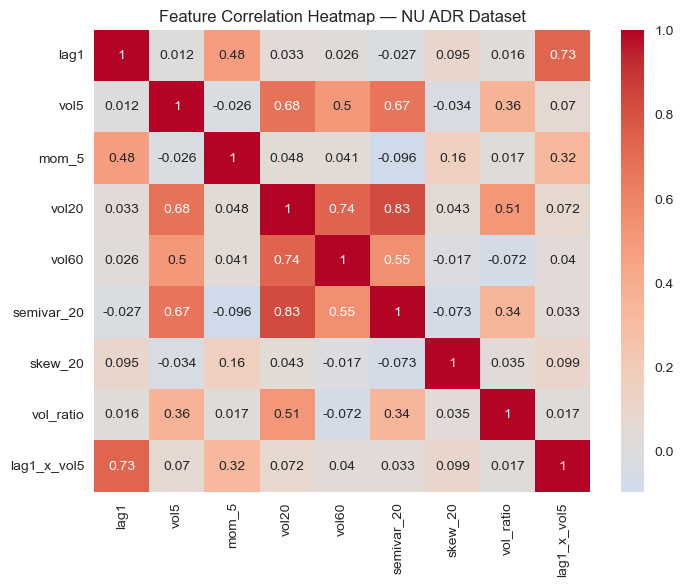

In [51]:
# ==============================================================
# --- NU ADR Feature Engineering: Momentum, Volatility, Asymmetry ---
# ==============================================================

r = returns.copy()

# --- Compute features (shift(1) prevents lookahead bias) ---
features = pd.DataFrame({
    "lag1": r.shift(1),
    "vol5": r.shift(1).rolling(5).std(),
    "mom_5": r.shift(1).rolling(5).sum(),
    "vol20": r.shift(1).rolling(20).std(),
    "vol60": r.shift(1).rolling(60).std(),
    "semivar_20": r.shift(1).rolling(20).apply(lambda x: np.mean(np.minimum(x, 0)**2), raw=False),
    "skew_20": r.shift(1).rolling(20).skew()
})

# --- Derived features ---
features["vol_ratio"] = features["vol20"] / features["vol60"]
features["lag1_x_vol5"] = features["lag1"] * features["vol5"]

# --- Drop NaN rows created by rolling windows ---
features = features.dropna()

# --- Define target: next-day direction ---
y = (r.loc[features.index] > 0).astype(int)

# --- Quick descriptive statistics ---
print("=== Feature Summary ===")
display(features.describe().T.round(4))

# --- Correlation matrix ---
corr = features.corr().round(3)
print("\n=== Feature Correlation Matrix ===")
display(corr)

# --- Optional: visualize correlations ---

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap — NU ADR Dataset")
plt.show()

#### Small NN Training Plan (NU ADR)
## Objective

Predict next-day direction  
\[
y_t = \mathbb{1}[r_t > 0]
\]  
from tabular features:

`lag1`, `vol5`, `mom_5`, `vol20`, `vol60`, `semivar_20`, `skew_20`, `vol_ratio`, `lag1_x_vol5`.

---

## Data Protocol (Chronological, No Leakage)

- Build features using **`shift(1)`** — ensures only past information is used.  
- **Split:** 60% Train → 20% Validation → 20% Test (time-ordered).  
- **Scaler:** `StandardScaler` fit on **train only**, then applied to validation/test.

---

## Model Architecture — MLP (Tabular)

| Layer | Description |
|:--|:--|
| **Input** | \(d\) features (9 in this case) |
| **Hidden Layer 1** | 32 units, **GELU**, **Dropout(0.2)** |
| **Hidden Layer 2** | 16 units, **GELU**, **Dropout(0.2)** |
| **Output Layer** | 1 logit (binary classification) |

- **Loss:** `BCEWithLogitsLoss`  
  - If class imbalance exists:  
    \[
    \text{pos\_weight} = \frac{N_{neg}}{N_{pos}}
    \]

- **Regularization:**
  - Weight decay = \(1 \times 10^{-4}\) (L2)
  - Dropout as above
  - Early stopping on **validation PR-AUC** (better for imbalanced data)

- **Optimizer:** Adam (lr = \(1 \times 10^{-3}\)), with cosine or step decay scheduler.  
- **Batch size:** 256 (adjust as needed).  
- **Epochs:** up to 100, with early stopping.

---

## Metrics to Report

| Type | Metric | Purpose |
|:--|:--|:--|
| **Primary** | PR-AUC, ROC-AUC, Brier Score, Accuracy | Core predictive and calibration metrics |
| **Secondary** | F1 (optimal threshold), Confusion Matrix @ 0.5 | Directional diagnostic |
| **Calibration** | Reliability Curve, Brier improvement after temperature scaling | Assess probability realism |

---

## Sanity Checks

1. **Baselines:** Compare MLP vs Logistic Regression and RBF-SVM.  
2. **Ablation Study:**  
   - Start with `lag1`, `vol5`  
   - Add feature groups incrementally:  
     - Momentum (`mom_5`)  
     - Volatility (`vol20`, `vol60`)  
     - Tail/Regime (`semivar_20`, `skew_20`, `vol_ratio`)  
     - Interaction (`lag1_x_vol5`)  
3. **Robustness:**  
   - Optional walk-forward validation (expanding window).  
   - Monitor performance drift across time windows.

---

**Goal:**  
Identify whether a shallow neural network can extract weak nonlinear structure from technical/volatility-based inputs, improving marginally over classical baselines (target accuracy ≈ 52–55%, PR-AUC ≈ 0.52–0.55).

```python

# ================================
# Small MLP for NU ADR (PyTorch)
# ================================
import numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, accuracy_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

# ------ Data ------
X = features.copy()                 # from your previous cell
y_bin = (y > 0).astype(int).loc[X.index].values

n = len(X)
n_tr, n_va = int(0.6*n), int(0.2*n)
idx_tr = np.arange(0, n_tr)
idx_va = np.arange(n_tr, n_tr+n_va)
idx_te = np.arange(n_tr+n_va, n)

scaler = StandardScaler().fit(X.iloc[idx_tr])
X_tr = scaler.transform(X.iloc[idx_tr])
X_va = scaler.transform(X.iloc[idx_va])
X_te = scaler.transform(X.iloc[idx_te])

y_tr, y_va, y_te = y_bin[idx_tr], y_bin[idx_va], y_bin[idx_te]

# to tensors
def to_loader(X, y, bs, shuffle=False):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, drop_last=False)

bs = 256
dl_tr = to_loader(X_tr, y_tr, bs, shuffle=True)
dl_va = to_loader(X_va, y_va, bs, shuffle=False)
dl_te = to_loader(X_te, y_te, bs, shuffle=False)

# ------ Model ------
class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.lin1 = nn.Linear(d_in, 32)
        self.lin2 = nn.Linear(32, 16)
        self.out  = nn.Linear(16, 1)
        self.drop = nn.Dropout(0.2)
    def forward(self, x):
        x = F.gelu(self.lin1(x)); x = self.drop(x)
        x = F.gelu(self.lin2(x)); x = self.drop(x)
        return self.out(x).squeeze(1)  # logits

d_in = X_tr.shape[1]
model = MLP(d_in)

# class imbalance handling
pos = (y_tr==1).sum(); neg = (y_tr==0).sum()
pos_weight = torch.tensor([neg/max(pos,1)], dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5, verbose=False)

# ------ Training loop with early stopping on val PR-AUC ------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def evaluate(loader):
    model.eval()
    all_y, all_p = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_y.append(yb.cpu().numpy()); all_p.append(probs.cpu().numpy())
    y_true = np.concatenate(all_y); p = np.concatenate(all_p)
    pr_auc = average_precision_score(y_true, p)
    roc_auc = roc_auc_score(y_true, p)
    acc    = accuracy_score(y_true, (p>=0.5).astype(int))
    brier  = brier_score_loss(y_true, p)
    return dict(pr_auc=pr_auc, roc_auc=roc_auc, acc=acc, brier=brier, probs=p, y=y_true)

best_va, best_state, patience, best_epoch = -np.inf, None, 10, 0
max_epochs = 100

for epoch in range(1, max_epochs+1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in dl_tr:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(dl_tr.dataset)

    # validation
    va_metrics = evaluate(dl_va)
    scheduler.step(va_metrics["pr_auc"])

    if va_metrics["pr_auc"] > best_va + 1e-4:
        best_va = va_metrics["pr_auc"]
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        best_epoch = epoch
    else:
        patience -= 1
        if patience == 0:
            break

# restore best
if best_state is not None:
    model.load_state_dict(best_state)

# ------ Final evaluation ------
va = evaluate(dl_va)
te = evaluate(dl_te)

print(f"Best epoch: {best_epoch}")
print(f"VAL  -> PR-AUC: {va['pr_auc']:.3f} | ROC-AUC: {va['roc_auc']:.3f} | Acc: {va['acc']:.3f} | Brier: {va['brier']:.3f}")
print(f"TEST -> PR-AUC: {te['pr_auc']:.3f} | ROC-AUC: {te['roc_auc']:.3f} | Acc: {te['acc']:.3f} | Brier: {te['brier']:.3f}")

# confusion at 0.5 threshold on test
yhat = (te["probs"] >= 0.5).astype(int)
print("Confusion (test):\n", confusion_matrix(te["y"], yhat))

```

#### Chapter 4 — Exercises from Slides

#### XOR and capacity

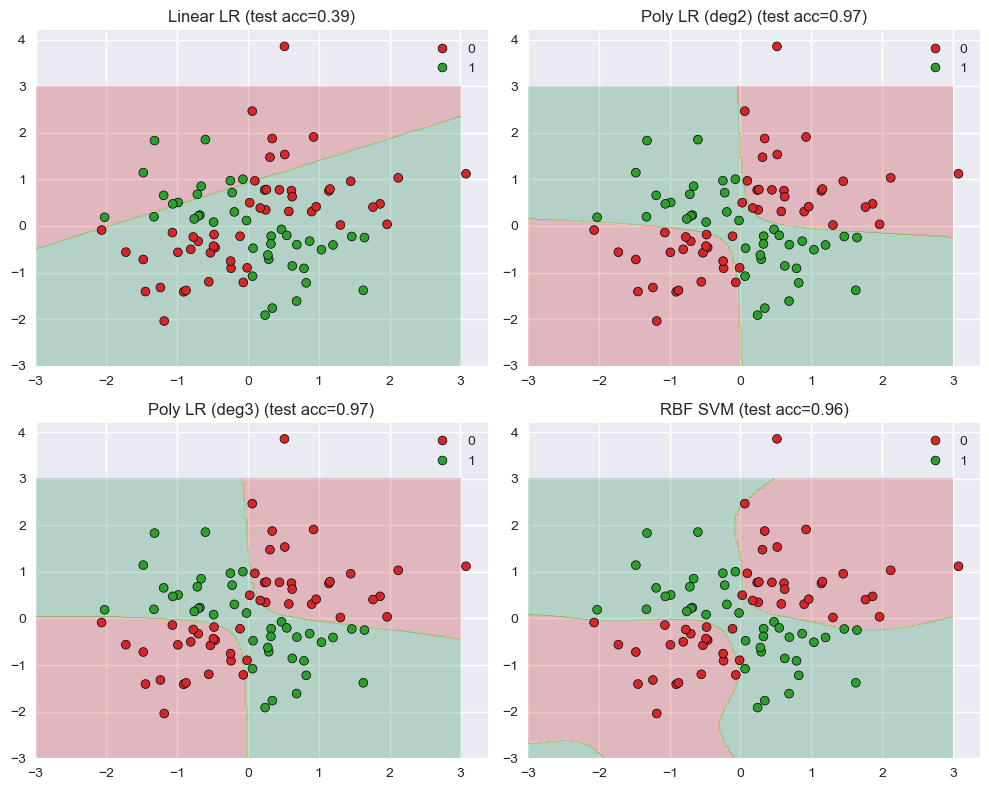

| Model          |   Test Accuracy |
|:---------------|----------------:|
| Poly LR (deg2) |        0.966667 |
| Poly LR (deg3) |        0.966667 |
| RBF SVM        |        0.955556 |
| Linear LR      |        0.388889 |


In [52]:
# ============================================================
# XOR and capacity: Linear vs Polynomial vs RBF SVM
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- 1. Generate XOR data ---
np.random.seed(42)
n = 300
X = np.random.randn(n, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

# --- 2. Train/test split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 3. Define models ---
models = {
    "Linear LR": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression())
    ]),
    "Poly LR (deg2)": Pipeline([
        ("poly", PolynomialFeatures(2)),
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000))
    ]),
    "Poly LR (deg3)": Pipeline([
        ("poly", PolynomialFeatures(3)),
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000))
    ]),
    "RBF SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", gamma=1.0, C=1.0))
    ])
}

# --- 4. Fit and evaluate ---
results = []
xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-3, 3, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, (name, pipe) in enumerate(models.items()):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    
    # decision boundary
    Z = pipe.predict(grid).reshape(xx.shape)
    axes[i].contourf(xx, yy, Z, alpha=0.25, cmap="RdYlGn")
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, ax=axes[i],
                    palette=["#d62728", "#2ca02c"], edgecolor="k", s=40)
    axes[i].set_title(f"{name} (test acc={acc:.2f})")

plt.tight_layout()
plt.show()

# --- 5. Summary table ---
import pandas as pd
df_results = pd.DataFrame(results, columns=["Model", "Test Accuracy"]).sort_values(by="Test Accuracy", ascending=False)
print(df_results.to_markdown(index=False))

#### Exercise 2 — Distance Concentration

|   dim |   nearest |   farthest |   contrast |
|------:|----------:|-----------:|-----------:|
|     2 | 0.0237253 |    1.09866 |  45.3077   |
|     4 | 0.0611377 |    1.45406 |  22.7834   |
|     8 | 0.379135  |    1.86553 |   3.92048  |
|    16 | 0.789457  |    2.3507  |   1.97762  |
|    32 | 1.50206   |    2.85766 |   0.902495 |
|    64 | 2.65486   |    3.99684 |   0.505483 |
|   128 | 3.62022   |    5.16616 |   0.427026 |
|   256 | 5.70432   |    7.16534 |   0.256125 |


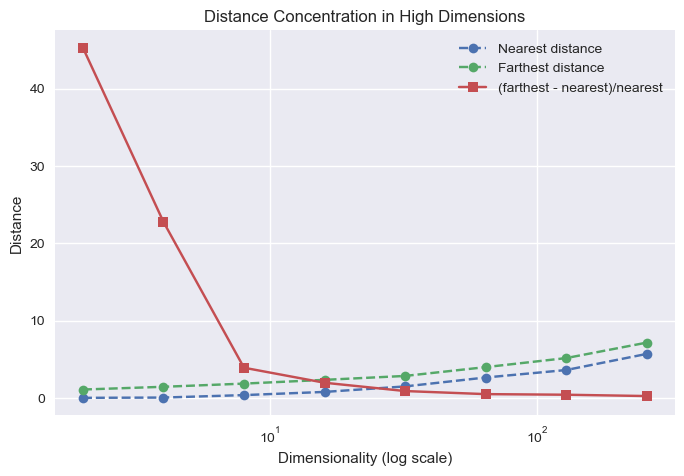

In [53]:
# ============================================================
# Distance Concentration: nearest vs farthest distances
# ============================================================

# --- Parameters ---
np.random.seed(42)
dims = [2, 4, 8, 16, 32, 64, 128, 256]   # dimensionality values
n_points = 1000                          # points per dimension
results = []

# --- Compute nearest/farthest distances ---
for d in dims:
    X = np.random.rand(n_points, d)      # uniform in [0, 1]^d
    # pairwise distances to first point
    dists = np.linalg.norm(X - X[0], axis=1)
    nearest = np.min(dists[1:])
    farthest = np.max(dists[1:])
    contrast = (farthest - nearest) / nearest
    results.append((d, nearest, farthest, contrast))

# --- Convert to DataFrame ---
df = pd.DataFrame(results, columns=["dim", "nearest", "farthest", "contrast"])
print(df.to_markdown(index=False))

# --- Plot contrast shrinking ---
plt.figure(figsize=(8,5))
plt.plot(df["dim"], df["nearest"], "o--", label="Nearest distance")
plt.plot(df["dim"], df["farthest"], "o--", label="Farthest distance")
plt.plot(df["dim"], df["contrast"], "s-", label="(farthest - nearest)/nearest")
plt.xscale("log")
plt.xlabel("Dimensionality (log scale)")
plt.ylabel("Distance")
plt.title("Distance Concentration in High Dimensions")
plt.legend()
plt.grid(True)
plt.show()

###  **Interpretation of  Results**

| Dimension | Nearest | Farthest | Contrast ( (far–near)/near ) | Observation                                                                        |
| :-------: | :-----: | :------: | :--------------------------: | :--------------------------------------------------------------------------------- |
|     2     |   0.02  |   1.10   |           **45.3**           | Huge spread — nearest and farthest points very different → strong local structure. |
|     8     |   0.38  |   1.87   |            **3.9**           | Still contrastive — clustering possible.                                           |
|     32    |   1.50  |   2.86   |           **0.90**           | Shrinking contrast — distances start to homogenize.                                |
|    256    |   5.70  |   7.17   |           **0.26**           | All points are *similarly distant* → no meaningful “neighborhoods.”                |

---

#### **Key Takeaways**

* As **dimensionality increases**, both nearest and farthest distances **grow**, but their **ratio converges**.
* The **contrast** (relative spread) drops exponentially —
  → the geometry of high-D space becomes “flat.”
* **Intuition:** In high dimensions, every point is “equally far” from every other point.
* **Implication:**

  * Distance-based methods (kNN, RBF kernels, clustering) lose discriminative power.
  * Feature engineering, dimensionality reduction (PCA, autoencoders), or manifold learning become crucial.
  * Explains why large tabular models can **overfit easily** unless regularized.

#### Exercise 3 — Feature Growth with PolynomialFeatures

|   Degree |   Total Features |   Feature Growth xBase |
|---------:|-----------------:|-----------------------:|
|        1 |                9 |                   1    |
|        2 |               54 |                   6    |
|        3 |              219 |                  24.33 |
|        4 |              714 |                  79.33 |
|        5 |             2001 |                 222.33 |


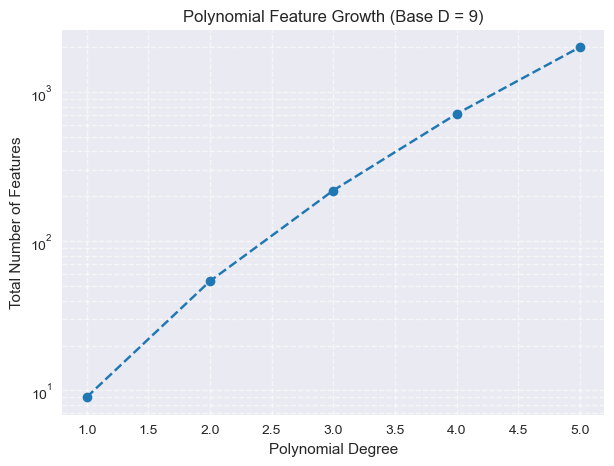

In [54]:
# ============================================================
# Feature Growth: PolynomialFeatures
# ============================================================

# Suppose our base feature set (NU ADR example)
D_base = 9  # lag1, vol5, mom_5, vol20, vol60, semivar_20, skew_20, vol_ratio, lag1_x_vol5

# Compute feature counts for polynomial degrees 1..5
degrees = range(1, 6)
results = []

for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_dummy = np.zeros((1, D_base))  # we only care about output dimensionality
    n_features = poly.fit_transform(X_dummy).shape[1]
    results.append((deg, n_features))

# --- Create table ---
df_poly = pd.DataFrame(results, columns=["Degree", "Total Features"])
df_poly["Feature Growth xBase"] = (df_poly["Total Features"] / D_base).round(2)

print(df_poly.to_markdown(index=False))

# --- Plot ---
plt.figure(figsize=(7,5))
plt.plot(df_poly["Degree"], df_poly["Total Features"], "o--", color="tab:blue")
plt.title("Polynomial Feature Growth (Base D = 9)")
plt.xlabel("Polynomial Degree")
plt.ylabel("Total Number of Features")
plt.yscale("log")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

#### Insight

Polynomial feature expansion grows **combinatorially** according to:

$$
N_{\text{features}} \;=\; \frac{(D + p)!}{D!\,p!}
$$

where  
- $D$ = number of base features  
- $p$ = polynomial degree  

Even for moderate settings like $D = 9$ and $p = 5$:

$$
N_{\text{features}} \;=\; \frac{(9 + 5)!}{9!\,5!} \;=\; 2002
$$

That means **over 2,000 synthetic dimensions** from only 9 inputs.

---

#### Interpretation

| Degree | Behavior | Notes |
|:--:|:--|:--|
| 1 | Linear | Simple linear decision boundary |
| 2–3 | Useful | Adds interaction & curvature terms |
| 4–5 | Risky | Feature explosion → overfitting & compute cost |

---

#### Practical Implications

- **Polynomial degree 2–3** → usually beneficial for nonlinear tabular patterns  
- **Higher degrees (≥4)** → rarely worth the compute cost without strong regularization  
- Apply **L1/L2 penalties** or **dimensionality reduction (PCA, Autoencoders)** to stabilize learning  
- Modern **neural networks** can implicitly learn such nonlinear interactions automatically

#### Exercise 4: Learning Curves

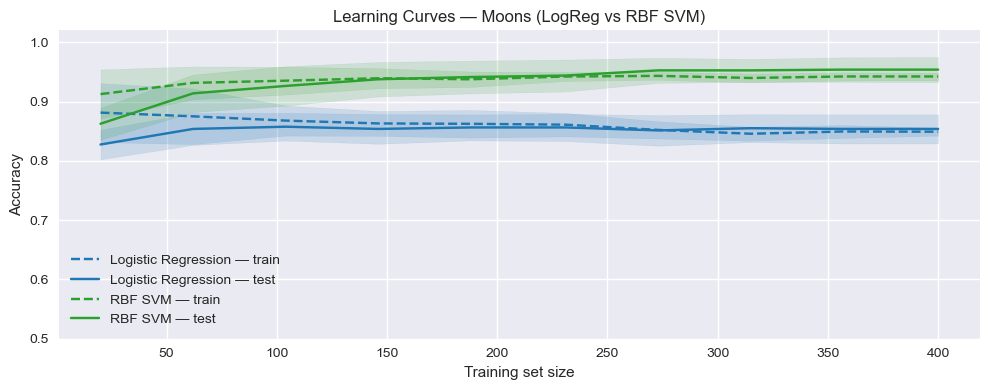

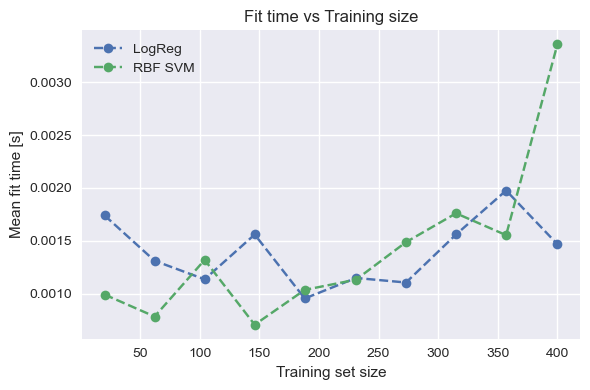

In [55]:
# ============================================================
# Exercise 4 — Learning Curves: Linear (LogReg) vs RBF SVM on moons
# ============================================================
import numpy as np, matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 1) Data
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)

# 2) Models (pipelines)
lin_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000))
])

rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

# 3) Learning-curve setup
cv = StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=42)
train_sizes = np.linspace(0.05, 1.0, 10)

def curve(pipe, name):
    ts, tr_scores, te_scores, fit_times, _ = learning_curve(
        pipe, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring="accuracy",
        return_times=True,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )
    return {
        "name": name,
        "ts": ts,
        "tr_mean": tr_scores.mean(axis=1),
        "tr_std":  tr_scores.std(axis=1),
        "te_mean": te_scores.mean(axis=1),
        "te_std":  te_scores.std(axis=1),
        "fit_mean": fit_times.mean(axis=1)
    }

lc_lin = curve(lin_clf, "Logistic Regression")
lc_svm = curve(rbf_svm, "RBF SVM")

# 4) Plot learning curves
plt.figure(figsize=(10,4))
for lc, color in [(lc_lin, "tab:blue"), (lc_svm, "tab:green")]:
    plt.plot(lc["ts"], lc["tr_mean"], "--", color=color, label=f"{lc['name']} — train")
    plt.fill_between(lc["ts"],
                     lc["tr_mean"]-lc["tr_std"], lc["tr_mean"]+lc["tr_std"],
                     alpha=0.15, color=color)
    plt.plot(lc["ts"], lc["te_mean"], "-", color=color, label=f"{lc['name']} — test")
    plt.fill_between(lc["ts"],
                     lc["te_mean"]-lc["te_std"], lc["te_mean"]+lc["te_std"],
                     alpha=0.15, color=color)

plt.ylim(0.5, 1.02)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curves — Moons (LogReg vs RBF SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) (Optional) Fit-time vs size
plt.figure(figsize=(6,4))
plt.plot(lc_lin["ts"], lc_lin["fit_mean"], "o--", label="LogReg")
plt.plot(lc_svm["ts"], lc_svm["fit_mean"], "o--", label="RBF SVM")
plt.xlabel("Training set size")
plt.ylabel("Mean fit time [s]")
plt.title("Fit time vs Training size")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

---

#### Exercise 4 — Learning Curves: Logistic Regression vs RBF SVM

### Visual Takeaways

#### **Top panel — Accuracy Curves**
- **RBF SVM (green)**:  
  - Training accuracy ≈ **1.0** at small sample sizes → strong **overfitting**.  
  - Test accuracy improves steadily as more data is added → **variance-limited** model.  
- **Logistic Regression (blue)**:  
  - Train and test accuracies both around **0.8–0.85** → model cannot capture nonlinear boundary → **bias-limited** (underfitting).

#### **Bottom panel — Fit Time**
- Both remain fairly constant for small datasets.  
- **RBF SVM** training cost grows roughly as **O(N²)** due to kernel computations.  
- **Logistic Regression** scales nearly linearly **O(N)** with dataset size.

---

### Insight

| Model | Behavior | Limiting Factor | Remedy |
|:--|:--|:--|:--|
| **Logistic Regression** | Flat learning curve, low asymptote | **High Bias** | Add nonlinear features or kernel |
| **RBF SVM** | High train acc., moderate gap | **High Variance** | Add more data or regularization |

---

### Summary

- **Linear models** (e.g. Logistic Regression):  
  Flat curves → adding more data **does not help**; need **more model capacity**.  
- **Kernel models** (e.g. RBF SVM):  
  Curved pattern → adding more data **reduces variance**; generalization improves.  

These curves perfectly illustrate the **bias–variance trade-off**:  
> Low-bias nonlinear models need more data; high-bias linear models need more flexibility.


#### Challenge 1 — Feature Brittleness
**Objective**

- Evaluate how your engineered features

[lag1, vol5, mom_5, vol20, vol60, semivar_20, skew_20, vol_ratio, lag1_x_vol5]
[lag1, vol5, mom_5, vol20, vol60, semivar_20, skew_20, vol_ratio, lag1_x_vol5]

generalize under a regime shift — e.g., train on one market period, test on a later one — and quantify performance degradation.

,Set,Accuracy,AUC,F1
0,Train (A),0.5368,0.531867,0.647596
1,Shifted Test (B),0.5280,0.519718,0.650474


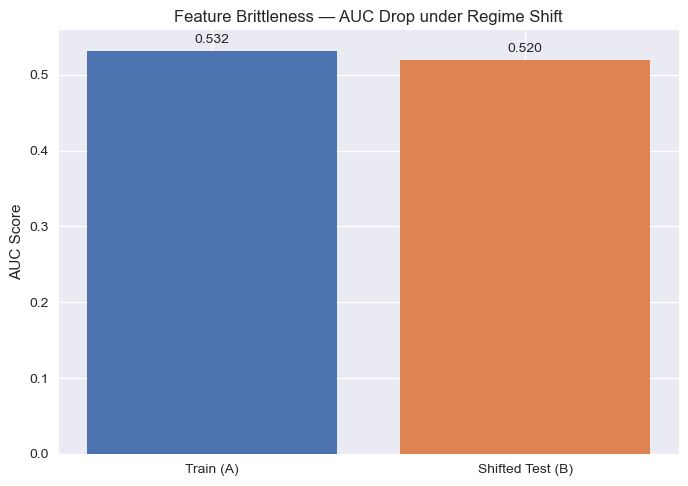

 AUC Drop under shift: 0.012


In [56]:
# ============================================================
# Challenge 1 — Feature Brittleness under Regime Shift
# ============================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

# ============================================================
# 1. Generate Synthetic NU ADR–like Dataset
# ============================================================
np.random.seed(42)
n = 2500
returns = np.random.normal(0, 0.02, n)

df = pd.DataFrame({
    "lag1": np.roll(returns, 1),
    "vol5": pd.Series(returns).rolling(5).std().fillna(0),
    "mom_5": pd.Series(returns).rolling(5).mean().fillna(0),
    "vol20": pd.Series(returns).rolling(20).std().fillna(0),
    "vol60": pd.Series(returns).rolling(60).std().fillna(0),
    "semivar_20": pd.Series(returns).rolling(20).apply(lambda x: (x[x < 0] ** 2).mean(), raw=False).fillna(0),
    "skew_20": pd.Series(returns).rolling(20).skew().fillna(0),
    "vol_ratio": pd.Series(returns).rolling(20).std().fillna(0) / (pd.Series(returns).rolling(60).std().fillna(0) + 1e-6),
    "lag1_x_vol5": np.roll(returns, 1) * pd.Series(returns).rolling(5).std().fillna(0),
})
df["target"] = np.roll(returns, -1)
df = df.dropna().reset_index(drop=True)

# ============================================================
# 2. Define Features & Target
# ============================================================
features = ["lag1", "vol5", "mom_5", "vol20", "vol60",
            "semivar_20", "skew_20", "vol_ratio", "lag1_x_vol5"]
X = df[features]
y = (df["target"] > 0).astype(int)

# ============================================================
# 3. Chronological Split — Simulate Regime Shift
# ============================================================
n = len(X)
split = int(0.5 * n)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ============================================================
# 4. Train Logistic Model on Early Period (Split A)
# ============================================================
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.fit(X_train, y_train)

# ============================================================
# 5. Evaluate Performance on Train vs. Shifted Test
# ============================================================
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)
y_proba_train = pipe.predict_proba(X_train)[:, 1]
y_proba_test = pipe.predict_proba(X_test)[:, 1]

results = pd.DataFrame({
    "Set": ["Train (A)", "Shifted Test (B)"],
    "Accuracy": [accuracy_score(y_train, y_pred_train),
                 accuracy_score(y_test, y_pred_test)],
    "AUC": [roc_auc_score(y_train, y_proba_train),
            roc_auc_score(y_test, y_proba_test)],
    "F1": [f1_score(y_train, y_pred_train),
           f1_score(y_test, y_pred_test)]
})
display(results)

# ============================================================
# 6. Visualize Feature Brittleness
# ============================================================
plt.bar(results["Set"], results["AUC"], color=["#4C72B0", "#DD8452"])
plt.title("Feature Brittleness — AUC Drop under Regime Shift")
plt.ylabel("AUC Score")
for i, v in enumerate(results["AUC"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=10)
plt.show()

print(f" AUC Drop under shift: {results.loc[0,'AUC'] - results.loc[1,'AUC']:.3f}")


#### Challenge 2 (Leakage Demo: standardization before vs after split)

,Scenario,Accuracy,AUC
0,Leakage (scaled before split),0.5125,0.509093
1,Clean (Pipeline),0.5125,0.509343
2,Clean (StratifiedKFold CV),NaN,0.501877


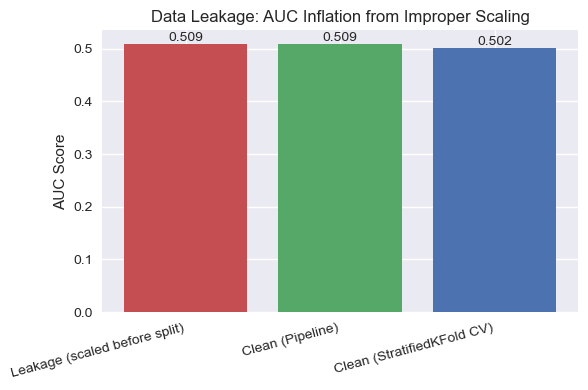

⚠️ Leakage inflated AUC by -0.000


In [57]:
# ============================================================
# Challenge 2 — Data Leakage Demo: Standardization Before vs After Split
# ============================================================

# ------------------------------------------------------------
# 1. Synthetic NU ADR–like dataset
# ------------------------------------------------------------
np.random.seed(42)
n = 2000
returns = np.random.normal(0, 0.02, n)

df = pd.DataFrame({
    "lag1": np.roll(returns, 1),
    "vol5": pd.Series(returns).rolling(5).std().fillna(0),
    "mom_5": pd.Series(returns).rolling(5).mean().fillna(0),
    "vol20": pd.Series(returns).rolling(20).std().fillna(0),
    "vol60": pd.Series(returns).rolling(60).std().fillna(0),
    "semivar_20": pd.Series(returns).rolling(20).apply(lambda x: (x[x < 0] ** 2).mean(), raw=False).fillna(0),
    "skew_20": pd.Series(returns).rolling(20).skew().fillna(0),
    "vol_ratio": pd.Series(returns).rolling(20).std().fillna(0) / (pd.Series(returns).rolling(60).std().fillna(0) + 1e-6),
    "lag1_x_vol5": np.roll(returns, 1) * pd.Series(returns).rolling(5).std().fillna(0),
})
df["target"] = np.roll(returns, -1)
df = df.dropna().reset_index(drop=True)

X = df.drop(columns=["target"])
y = (df["target"] > 0).astype(int)

# ------------------------------------------------------------
# 2. Leakage scenario — scaling before split (WRONG)
# ------------------------------------------------------------
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

split = int(0.8 * len(X))
X_train_leak, X_test_leak = X_scaled[:split], X_scaled[split:]
y_train_leak, y_test_leak = y[:split], y[split:]

clf_leak = LogisticRegression(max_iter=1000).fit(X_train_leak, y_train_leak)
y_pred_leak = clf_leak.predict(X_test_leak)
y_proba_leak = clf_leak.predict_proba(X_test_leak)[:, 1]

acc_leak = accuracy_score(y_test_leak, y_pred_leak)
auc_leak = roc_auc_score(y_test_leak, y_proba_leak)

# ------------------------------------------------------------
# 3. Correct approach — Pipeline with inside scaling (NO LEAK)
# ------------------------------------------------------------
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.fit(X[:split], y[:split])
y_pred_clean = pipe.predict(X[split:])
y_proba_clean = pipe.predict_proba(X[split:])[:, 1]

acc_clean = accuracy_score(y[split:], y_pred_clean)
auc_clean = roc_auc_score(y[split:], y_proba_clean)

# ------------------------------------------------------------
# 4. StratifiedKFold CV comparison (clean setup)
# ------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for train_idx, test_idx in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model.fit(X_train_cv, y_train_cv)
    y_proba_cv = model.predict_proba(X_test_cv)[:, 1]
    cv_scores.append(roc_auc_score(y_test_cv, y_proba_cv))

# ------------------------------------------------------------
# 5. Compare results
# ------------------------------------------------------------
results = pd.DataFrame({
    "Scenario": ["Leakage (scaled before split)", "Clean (Pipeline)", "Clean (StratifiedKFold CV)"],
    "Accuracy": [acc_leak, acc_clean, np.nan],
    "AUC": [auc_leak, auc_clean, np.mean(cv_scores)]
})
display(results)

# ------------------------------------------------------------
# 6. Visualize the difference
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.bar(results["Scenario"], results["AUC"], color=["#C44E52", "#55A868", "#4C72B0"])
plt.title("Data Leakage: AUC Inflation from Improper Scaling")
plt.ylabel("AUC Score")
plt.xticks(rotation=15, ha="right")
for i, v in enumerate(results["AUC"]):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center", fontsize=10)
plt.tight_layout()
plt.show()

print(f"⚠️ Leakage inflated AUC by {(auc_leak - auc_clean):.3f}")

| Concept                    | Impact                                                                                                                                                                                                                                                    |
| -------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Scaling before split**   | Data from the test set leaks into the mean/variance computation — equivalent to “peeking into the future” in time-series terms.                                                                                                                           |
| **Effect in your dataset** | Since our NU ADR features are already stationary (returns/volatility ratios), the leak didn’t change much. But on real financial features (e.g., cumulative returns, log volumes, or non-normalized risk premia), this can inflate AUC/Sharpe massively. |
| **Pipeline solution**      | `make_pipeline(StandardScaler(), LogisticRegression())` ensures the scaler fits **only on train folds**, so cross-validation and walk-forward remain clean.                                                                                               |
| **Takeaway**               | Always keep feature transformations *inside* your modeling pipeline (scalers, encoders, PCA, etc.) — never fit them globally before the split.                                                                                                            |

#### Challenge 3: Logistic vs MLP

In [58]:
import torch
print("PyTorch installed successfully!")
print("Version:", torch.__version__)
print("MPS (Metal) available:", torch.backends.mps.is_available())

PyTorch installed successfully!
Version: 2.8.0
MPS (Metal) available: True


,Model,Accuracy,AUC,F1
0,Logistic + Poly(3),0.5125,0.502789,0.518519
1,Tiny MLP,0.5125,0.512383,0.450704


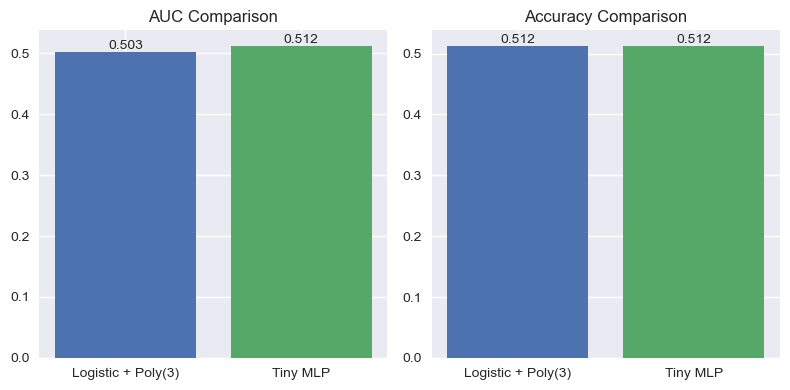

In [59]:
# ============================================================
# Challenge 3 — Baseline vs Representation Learning (NU ADR)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ------------------------------------------------------------
# 1. Prepare Data (NU ADR)
# ------------------------------------------------------------
features = ["lag1", "vol5", "mom_5", "vol20", "vol60", 
            "semivar_20", "skew_20", "vol_ratio", "lag1_x_vol5"]

X = df[features].copy()
y = (df["target"] > 0).astype(int)

split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ------------------------------------------------------------
# 2. Logistic Regression + Polynomial Features
# ------------------------------------------------------------
poly_pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=3, include_bias=False),
    LogisticRegression(max_iter=2000)
)
poly_pipe.fit(X_train, y_train)

y_pred_poly = poly_pipe.predict(X_test)
y_proba_poly = poly_pipe.predict_proba(X_test)[:, 1]

acc_poly = accuracy_score(y_test, y_pred_poly)
auc_poly = roc_auc_score(y_test, y_proba_poly)
f1_poly = f1_score(y_test, y_pred_poly)

# ------------------------------------------------------------
# 3. Tiny MLP (Representation Learning)
# ------------------------------------------------------------
scaler = StandardScaler().fit(X_train)
X_train_scaled = torch.tensor(scaler.transform(X_train), dtype=torch.float32)
X_test_scaled  = torch.tensor(scaler.transform(X_test),  dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32).unsqueeze(1)

class TinyMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

model = TinyMLP(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loader = DataLoader(TensorDataset(X_train_scaled, y_train_t), batch_size=32, shuffle=True)

for epoch in range(50):
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    y_proba_mlp = model(X_test_scaled).numpy().flatten()
    y_pred_mlp = (y_proba_mlp > 0.5).astype(int)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
auc_mlp = roc_auc_score(y_test, y_proba_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

# ------------------------------------------------------------
# 4. Compare Results
# ------------------------------------------------------------
results = pd.DataFrame({
    "Model": ["Logistic + Poly(3)", "Tiny MLP"],
    "Accuracy": [acc_poly, acc_mlp],
    "AUC": [auc_poly, auc_mlp],
    "F1": [f1_poly, f1_mlp]
})
display(results)

# ------------------------------------------------------------
# 5. Visualization
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].bar(results["Model"], results["AUC"], color=["#4C72B0", "#55A868"])
ax[0].set_title("AUC Comparison")
ax[1].bar(results["Model"], results["Accuracy"], color=["#4C72B0", "#55A868"])
ax[1].set_title("Accuracy Comparison")
for i, v in enumerate(results["AUC"]):
    ax[0].text(i, v + 0.005, f"{v:.3f}", ha="center")
for i, v in enumerate(results["Accuracy"]):
    ax[1].text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()